KR vs DH binary classifier
Script overview: 
1. Block 1 of the script imports KS domains from files in "route" and combines with substrate labels generated from file "labels_sheet", then balances the dataset based on the minimal category 
2. Block 2 generates graph networks from carbon alphas using a k-nearest neighbour method. Features are supplied as a OHE of amino acid type. Labels are unified in the graph constructor as graph_y.
3. Block 3 is a dataloader. KS substrate type is balanced in this block for Train, Validation and Test data.
4. Block 4 contains the GNN model, training loop and test step.
5. Block 5  loop that explains each graph in the test data partition.

Label distribution BEFORE balancing (excluding rows with KRa=0 and KRb=0):
KRa value counts:
1    161
0    159
Name: KRa, dtype: int64

KRb value counts:
0    161
1    159
Name: KRb, dtype: int64

Combined (KRa, KRb) value counts:
KRa  KRb
0    1      159
1    0      161
dtype: int64

Label distribution AFTER balancing:
KRa value counts:
0    159
1    159
Name: KRa, dtype: int64

KRb value counts:
1    159
0    159
Name: KRb, dtype: int64

Combined (KRa, KRb) value counts:
KRa  KRb
0    1      159
1    0      159
dtype: int64

Sample of balanced file paths and corresponding labels:
                                               paths  KRa  KRb
0  /home/q31032mw/Dropbox (The University of Manc...    0    1
1  /home/q31032mw/Dropbox (The University of Manc...    0    1
2  /home/q31032mw/Dropbox (The University of Manc...    0    1
3  /home/q31032mw/Dropbox (The University of Manc...    0    1
4  /home/q31032mw/Dropbox (The University of Manc...    0    1
Label distribution BEFORE balanci

[07/13/25 12:39:20] WARNING  To use the Graphein submodule                                         ]8;id=311788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=832899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[07/13/25 12:39:21] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=127962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=193691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning: The default 
value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning: The default 
value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=915121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=286323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 860 total nodes                                                 ]8;id=938899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=256217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

                    INFO     Found: 3440 KNN edges                                                 ]8;id=522615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=819927;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py#1130\1130]8;;\

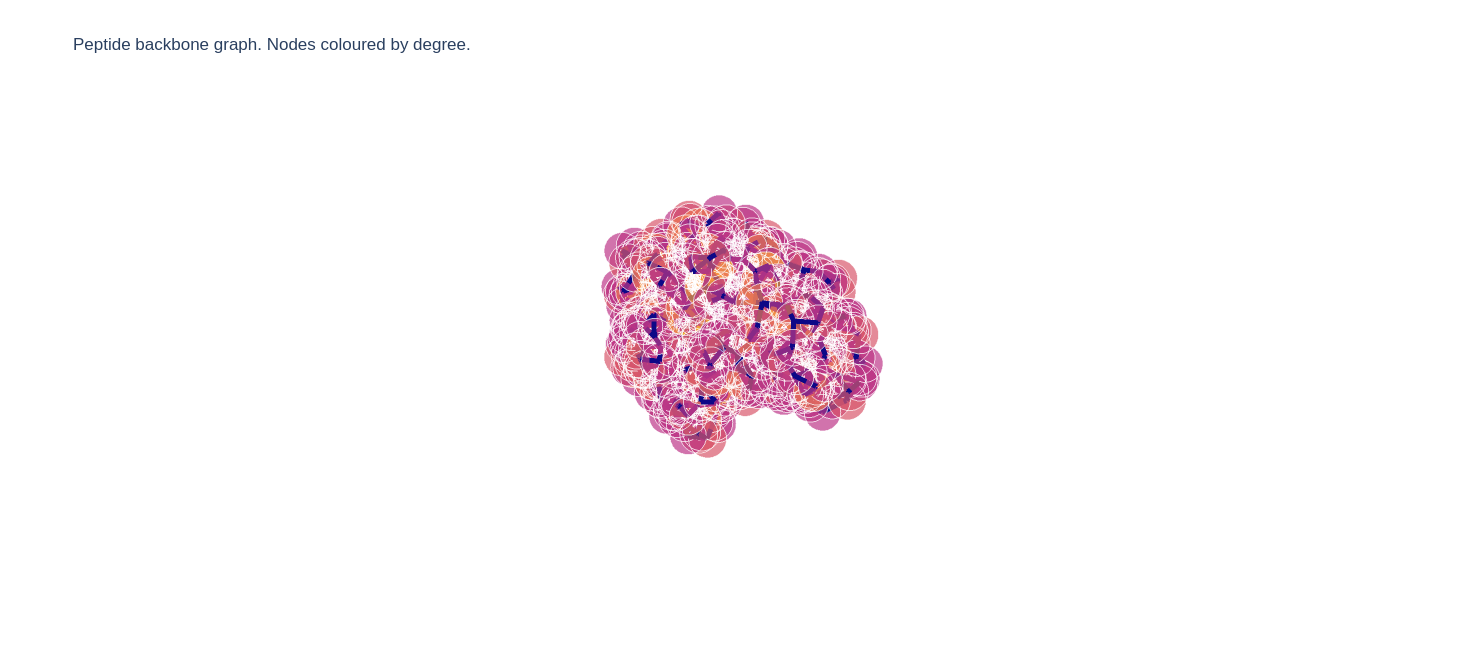

Graph dataset creation complete.
ProteinGraphDataset(318)
Number of graphs: 318


In [1]:
import os
import pandas as pd
import re

# Load labels
labels = pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20250619_KR_types_expanded.csv", index_col=0)

# Get all PDB file paths
directory_path = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240911_KS_dimers_extras_aligned_reviewed/"  
absolute_file_paths = [os.path.join(root, file)
                       for root, _, files in os.walk(directory_path)
                       for file in files if file.endswith('.pdb')]

# Extract gene names from filenames (e.g., "hitP4_Mod.2.pdb" -> "hitP4_Mod.2")
def extract_gene_name(filename):
    return re.match(r'(.+)\.', os.path.splitext(os.path.basename(filename))[0]).group(1)

# Build a dictionary mapping gene names to file paths
gene_to_path = {}
for path in absolute_file_paths:
    gene_name = extract_gene_name(path)
    gene_to_path[gene_name] = path  # If duplicates exist, last one wins

# Filter labels to only those with a matching path
filtered_labels = labels[labels.index.isin(gene_to_path.keys())].copy()

# Add file paths column based on label index order
filtered_labels["paths"] = filtered_labels.index.map(gene_to_path)

from sklearn.utils import resample
import pandas as pd

# Step 1: Remove rows where both KRa and KRb are 0
filtered_labels_nonzero = filtered_labels[~((filtered_labels['KRa'] == 0) & (filtered_labels['KRb'] == 0))]

# Report label distribution before balancing
print("Label distribution BEFORE balancing (excluding rows with KRa=0 and KRb=0):")
print("KRa value counts:")
print(filtered_labels_nonzero['KRa'].value_counts())
print("\nKRb value counts:")
print(filtered_labels_nonzero['KRb'].value_counts())
print("\nCombined (KRa, KRb) value counts:")
print(filtered_labels_nonzero.groupby(['KRa', 'KRb']).size())

# Step 2: Group by both KRa and KRb
grouped = filtered_labels_nonzero.groupby(['KRa', 'KRb'])

# Step 3: Find the size of the smallest group (for downsampling)
min_size = grouped.size().min()

# Step 4: Downsample each group to match the smallest group size
balanced_df = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)

# Report label distribution after balancing
print("\nLabel distribution AFTER balancing:")
print("KRa value counts:")
print(balanced_df['KRa'].value_counts())
print("\nKRb value counts:")
print(balanced_df['KRb'].value_counts())
print("\nCombined (KRa, KRb) value counts:")
print(balanced_df.groupby(['KRa', 'KRb']).size())

# Optional: preview file paths and labels
print("\nSample of balanced file paths and corresponding labels:")
print(balanced_df[['paths', 'KRa', 'KRb']].head())

### --- Part 1: Balancing Labels --- ###
from sklearn.utils import resample
import pandas as pd
import torch

# Step 1: Filter out rows where both KRa and KRb are zero
filtered_labels_nonzero = filtered_labels[~((filtered_labels['KRa'] == 0) & (filtered_labels['KRb'] == 0))]

# Report BEFORE balancing
print("Label distribution BEFORE balancing:")
print(filtered_labels_nonzero.groupby(['KRa', 'KRb']).size())

# Step 2: Group and downsample to balance
grouped = filtered_labels_nonzero.groupby(['KRa', 'KRb'])
min_size = grouped.size().min()
balanced_df = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)

# Report AFTER balancing
print("\nLabel distribution AFTER balancing:")
print(balanced_df.groupby(['KRa', 'KRb']).size())

# Optional preview
print("\nSample of balanced file paths and corresponding labels:")
print(balanced_df[['paths', 'KRa', 'KRb']].head())

## --- Part 2: Graph Creation Config --- ###
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plotly_protein_structure_graph

new_edge_funcs = {
    "edge_construction_functions": [partial(add_k_nn_edges, k=4, long_interaction_threshold=0)],
    "node_metadata_functions": [amino_acid_one_hot]
}
import graphein
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

# OPTIONAL: Plot one graph
example_path = balanced_df['paths'].iloc[0]
g = construct_graph(config=config, path=example_path)
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
)
p.show()


### --- Part 3: PyG Dataset Creation --- ###
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# Required graph info for PyG conversion
info_list = [
    "edge_index", 
    "amino_acid_one_hot",
    "node_id", 
    "chain_id", 
    "residue_name", 
    "residue_number", 
    "atom_type", 
    "element_symbol",
    "coords",
    "b_factor", 
    "kind", 
    "name",
    "chain_ids"
]

convertor = GraphFormatConvertor(
    src_format="nx", 
    dst_format="pyg", 
    verbose="all_info", 
    columns=info_list
)

# Convert labels into list of tensors
graph_labels_list = [torch.tensor([row.KRa, row.KRb], dtype=torch.float32) for _, row in balanced_df.iterrows()]

# Convert paths to list
paths_list = balanced_df['paths'].tolist()

# Build dataset
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/120240911_KS_dimers_Reduction_State_K4_KRAvsKRB3',
    paths=paths_list,
    graphein_config=config,
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("Graph dataset creation complete.")
print(dataset)
print(f"Number of graphs: {len(graph_labels_list)}")

In [2]:
#### Block 3 #### 
### Data loader ### 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.74
val_ratio = 0.25
test_ratio = 0.01
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    KRa_count = 0
    KRb_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        KRa_count += labels.count([1, 0])
        KRb_count += labels.count([0, 1])
        total_count += len(labels)
    
    return KRa_count, KRb_count, total_count

# Calculate label composition for each loader
train_KRa, train_KRb, train_total = count_labels(train_loader)
val_KRa, val_KRb,  val_total = count_labels(val_loader)
test_KRa, test_KRb, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"KR: {train_KRa} samples, DH: {train_KRb} samples, Total: {train_total} samples")


print("\nValidation Set Composition:")
print(f"KR: {val_KRa} samples, DH: {val_KRb}, Total: {val_total} samples")


print("\nTest Set Composition:")
print(f"KR: {test_KRa} samples, DH: {test_KRb}, Total: {test_total} samples")


Train_set: 234
Val_set: 80
Test_set: 4
Training Set Composition:
KR: 117 samples, DH: 117 samples, Total: 234 samples

Validation Set Composition:
KR: 40 samples, DH: 40, Total: 80 samples

Test Set Composition:
KR: 2 samples, DH: 2, Total: 4 samples


In [3]:
#### Block 4 #### 
### Training and validation ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64 # Neural network density
output_dim = 2  # Set model to binary classification

# Hyperparameters
num_epochs = 250
learning_rate = 0.001

# Define a GNN model
# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.relu()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        #x = torch.relu(x)  # Sigmoid activation for binary classification
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())


    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


import pandas as pd
import os
from datetime import datetime

# Create the metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accuracies,
    'Validation_Accuracy': val_accuracies,
    'Train_AUC': train_aucs,
    'Validation_AUC': val_aucs
})

# Set your folder destination
output_folder = 'KRa vs KRb metrics'  # Customize if needed

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Generate timestamp without seconds
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
filename = f"KRa_vs_KRb_{timestamp}.csv"

# Full path to the output file
filepath = os.path.join(output_folder, filename)

# Save the DataFrame to CSV
metrics_df.to_csv(filepath, index=False)

print(f"Training metrics saved to '{filepath}'")


DataBatch(x=[54358, 20], edge_index=[2, 124750], node_id=[64], coords=[54358, 3], name=[64], num_nodes=54358, graph_y=[64, 2], batch=[54358], ptr=[65])
Epoch [1/250] - Train Loss: 0.6967 - Train Accuracy: 0.5000 - Train AUC: 0.4120 - Validation Loss: 0.6949 - Validation Accuracy: 0.5000 - Validation AUC: 0.3113
Epoch [2/250] - Train Loss: 0.6928 - Train Accuracy: 0.5000 - Train AUC: 0.5132 - Validation Loss: 0.6956 - Validation Accuracy: 0.5000 - Validation AUC: 0.2931
Epoch [3/250] - Train Loss: 0.6906 - Train Accuracy: 0.5513 - Train AUC: 0.5605 - Validation Loss: 0.6936 - Validation Accuracy: 0.5000 - Validation AUC: 0.3087


KeyboardInterrupt: 

In [61]:
import torch
torch.save(model.state_dict(), '.pth')
#print("Model saved successfully!")

In [4]:
# Initialize the model structure
model = MyGNN(input_dim, hidden_dim, output_dim)

# Load the saved model parameters
model.load_state_dict(torch.load('20250622_KRavsKRb_e250.pth'))

# Make sure the model is in evaluation mode if you're using it for inference
model.eval()


MyGNN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

Processing batch with 64 graphs
Explanation for graph btlA_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.7294e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


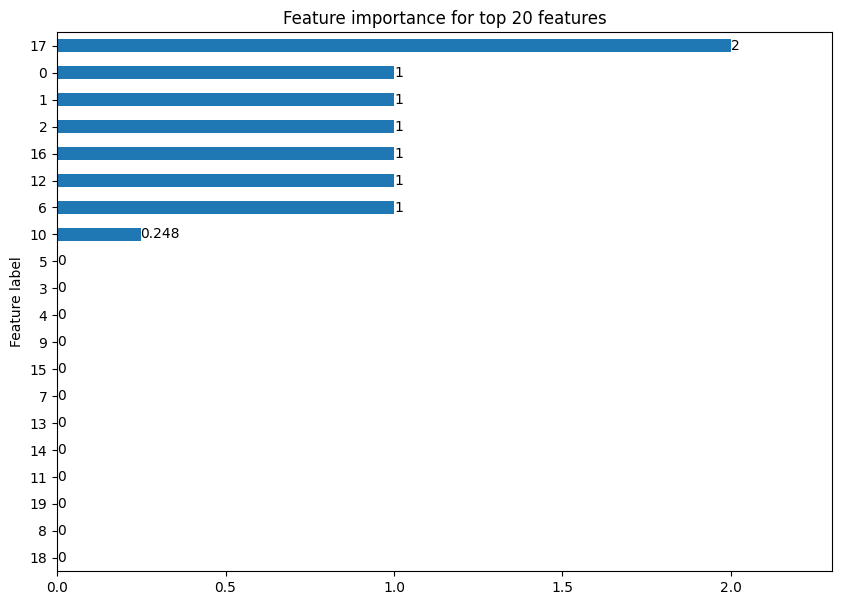

Explanation for graph SgnS2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.2496e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


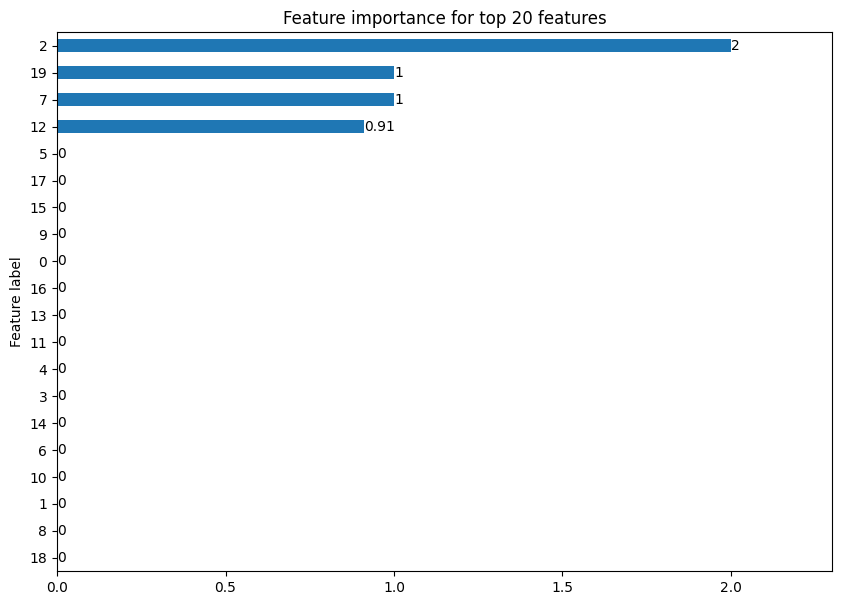

Explanation for graph olmA6_Mod.14.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[7.7532e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


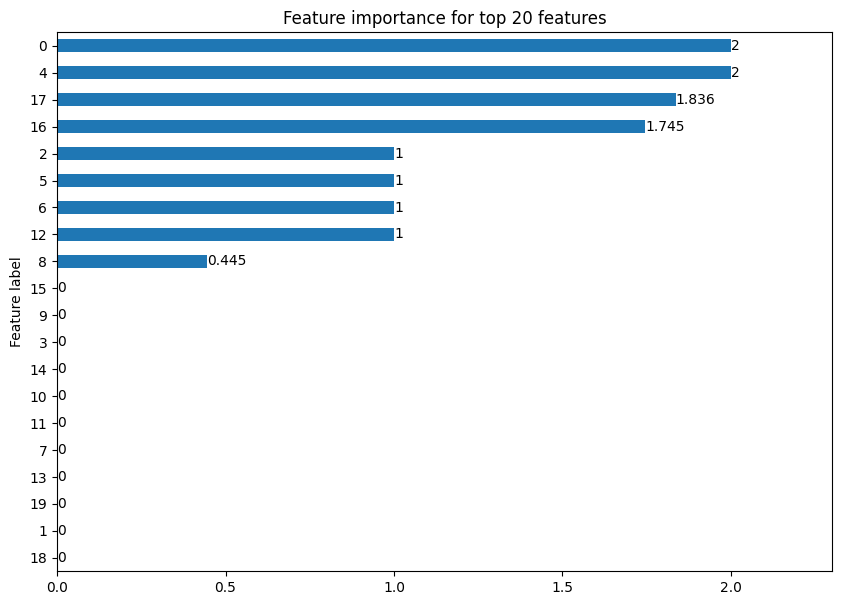

Explanation for graph slnA8_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


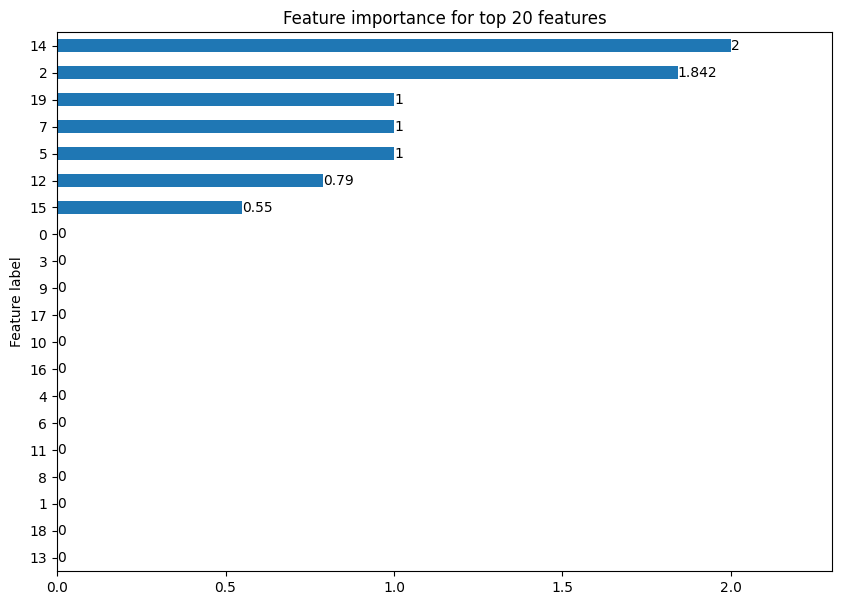

Explanation for graph flvP2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.4005e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


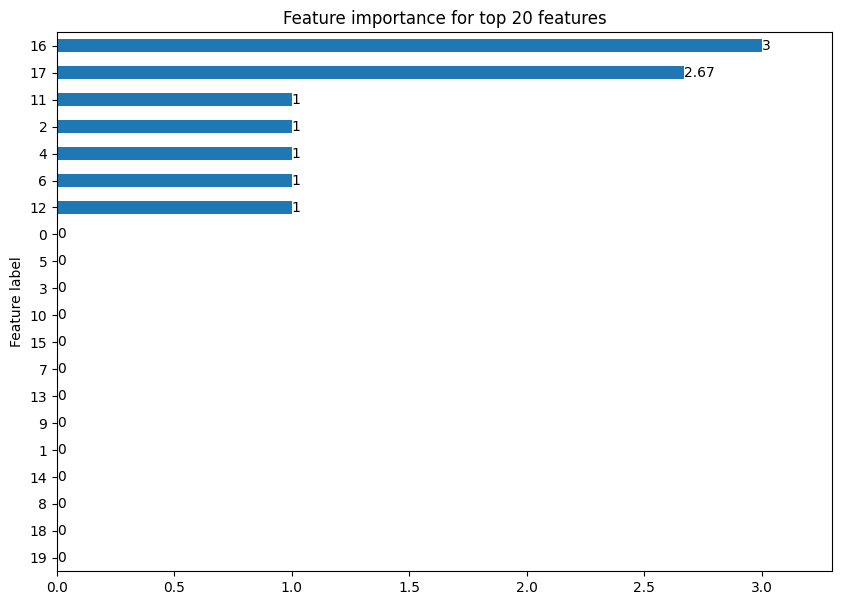

Explanation for graph cppI_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4603e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


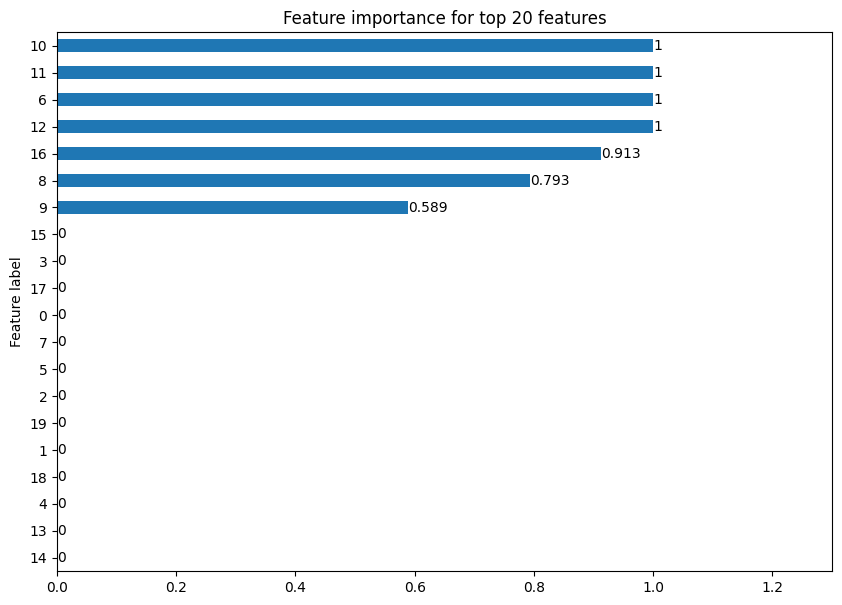

Explanation for graph nysJ_Mod.3.pdb_aligned: tensor([8.4552e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.2573e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


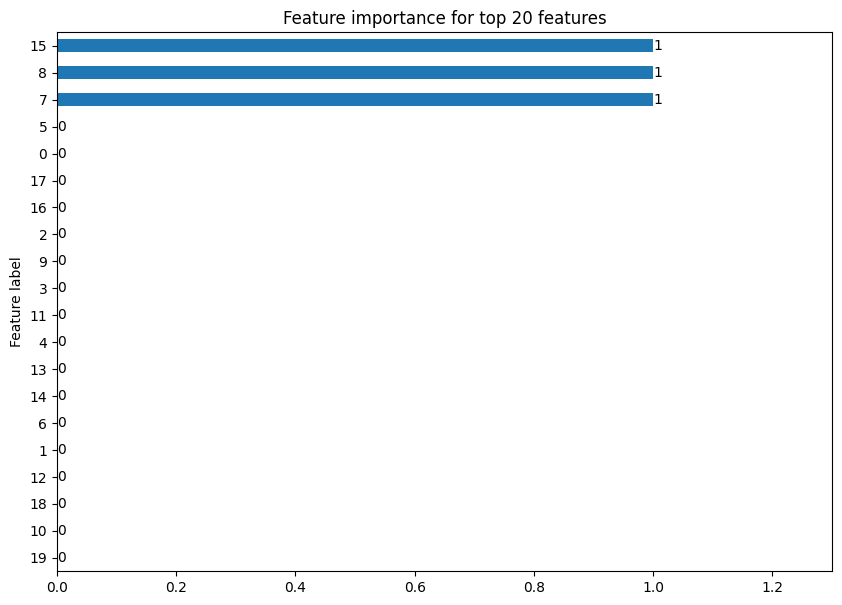

Explanation for graph nbrH_Mod.3.pdb_aligned: tensor([0.0000e+00, 8.0864e-11, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.4701e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


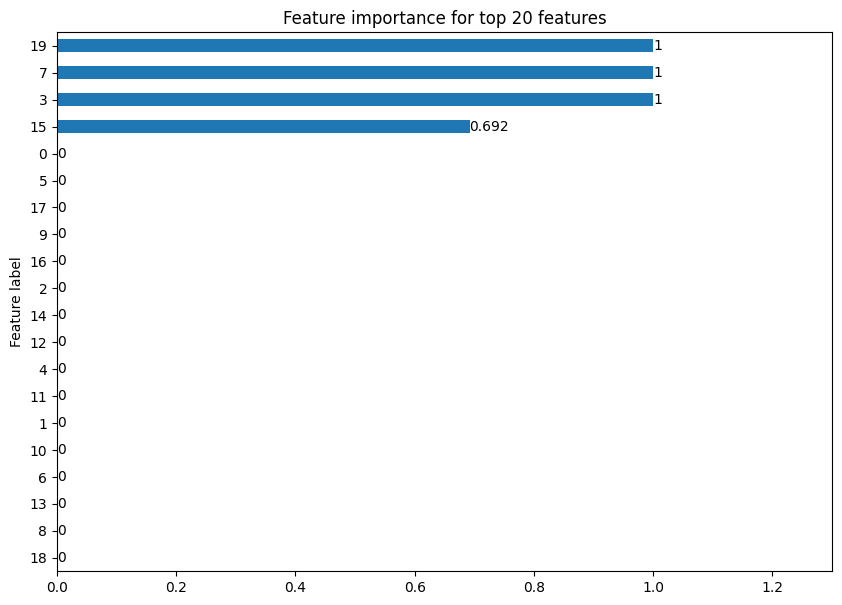

Explanation for graph aizC_mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


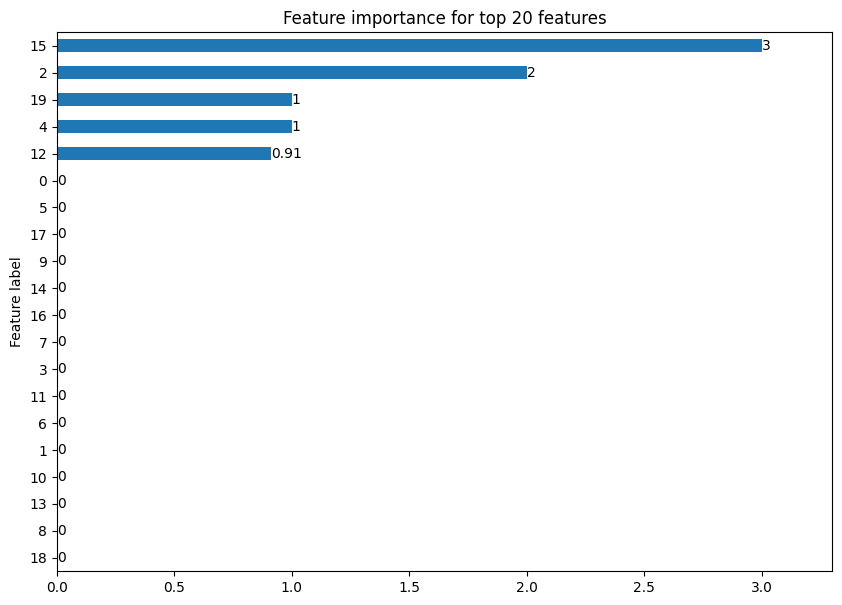

Explanation for graph becF_Mod.1.pdb_aligned: tensor([7.0618e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4727e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


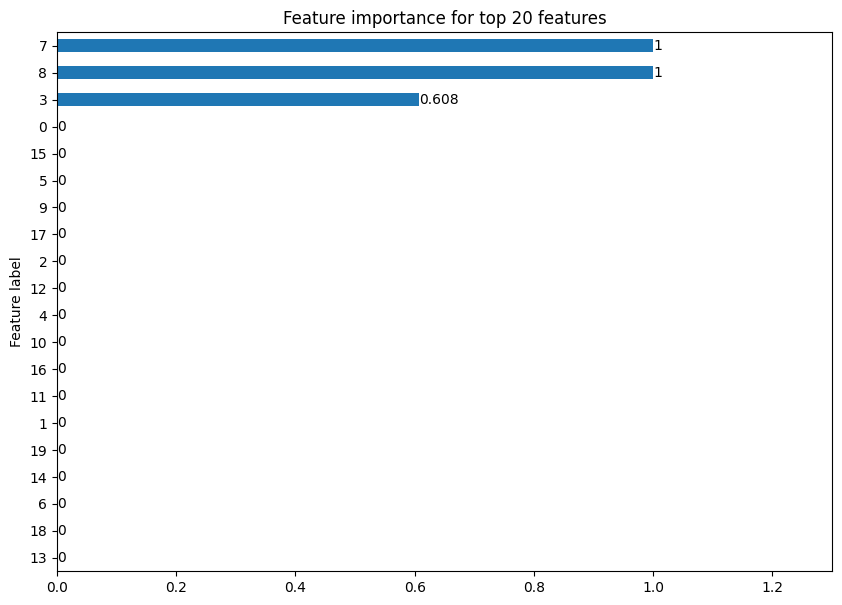

Explanation for graph hlsC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


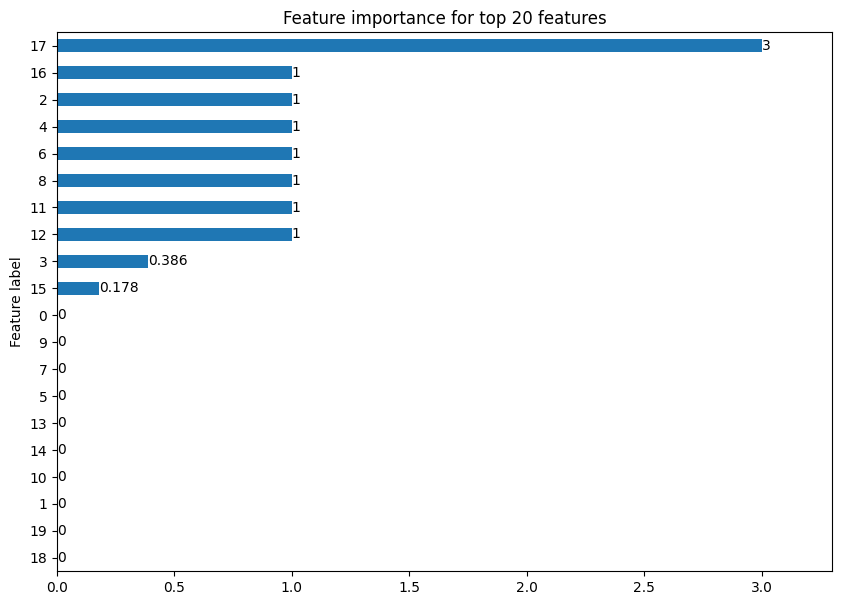

Explanation for graph rapC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


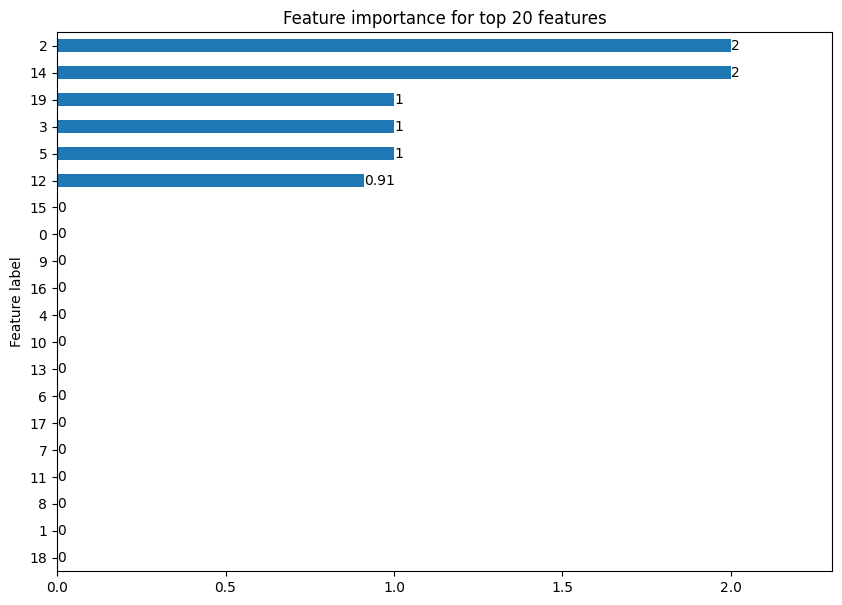

Explanation for graph olmA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


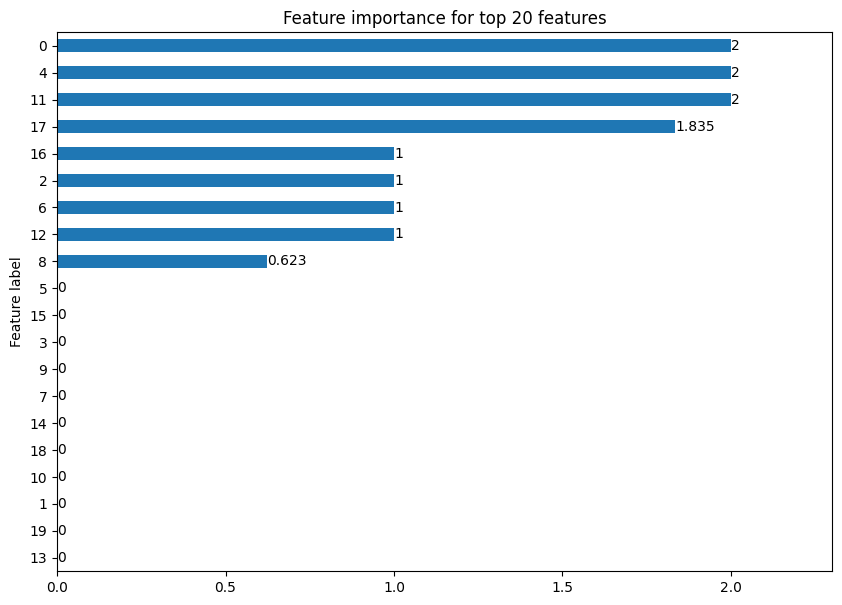

Explanation for graph spr11_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


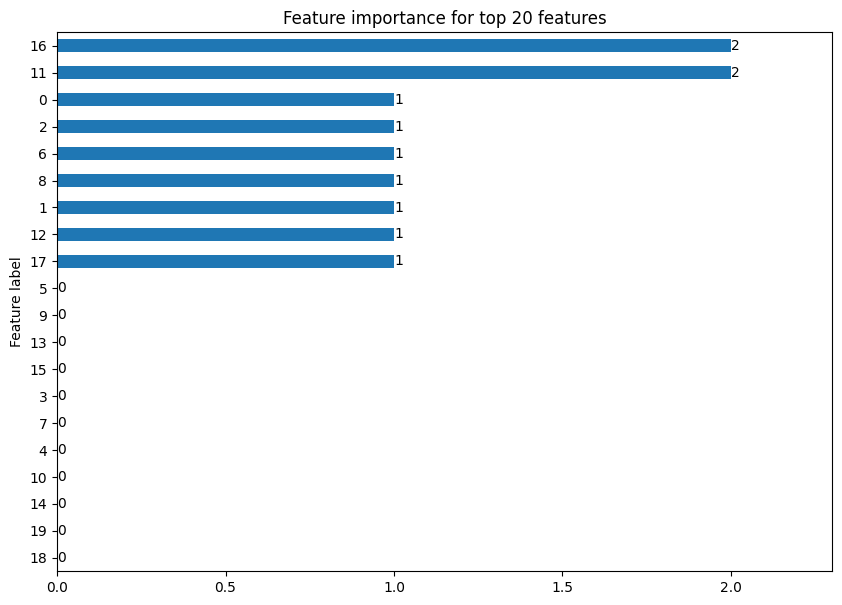

Explanation for graph cle3_Mod.5.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


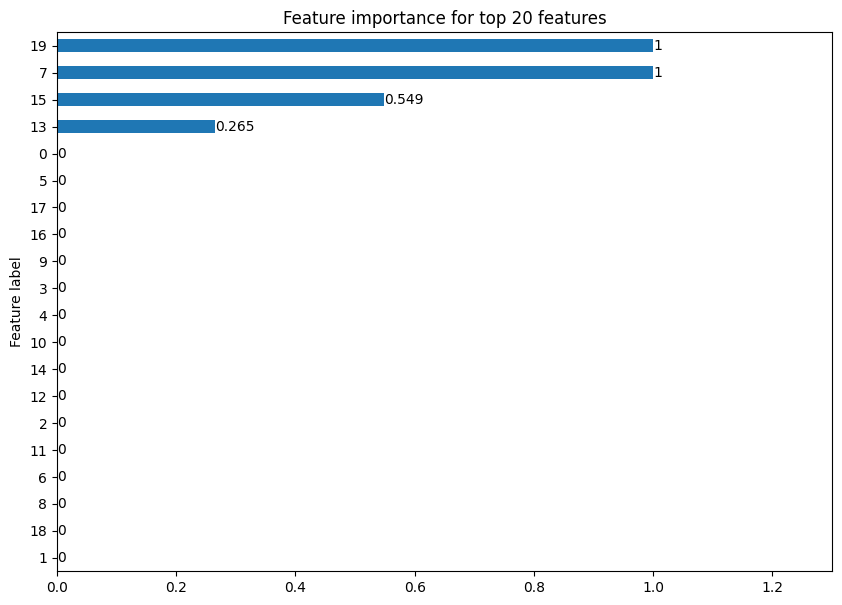

Explanation for graph eryAI_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0559e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


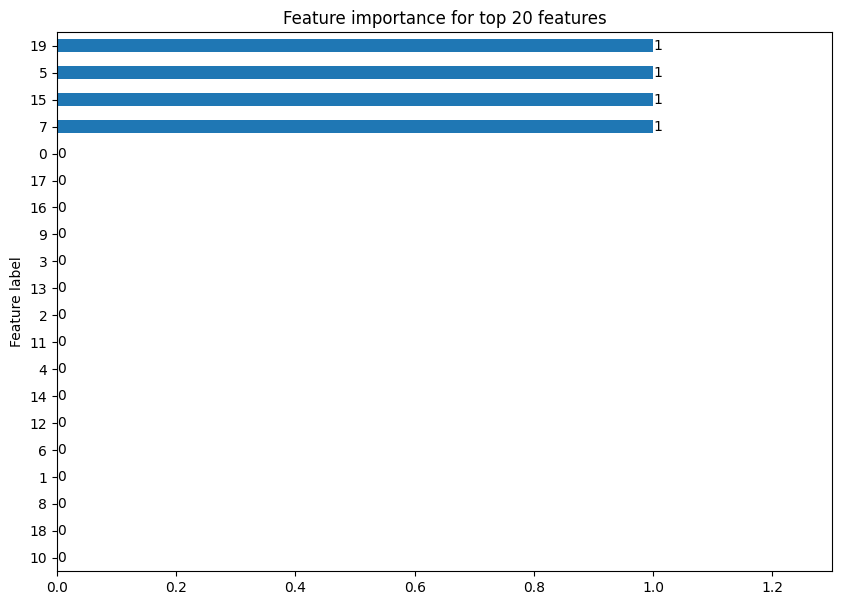

Explanation for graph epoC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2060e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


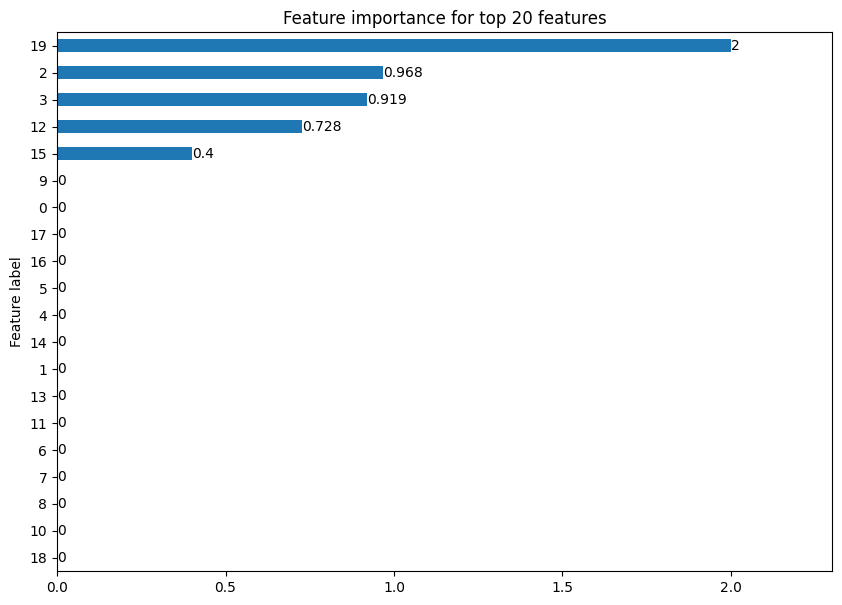

Explanation for graph asmA_Mod.2.pdb_aligned: tensor([9.4706e-11, 0.0000e+00, 9.4881e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.1247e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


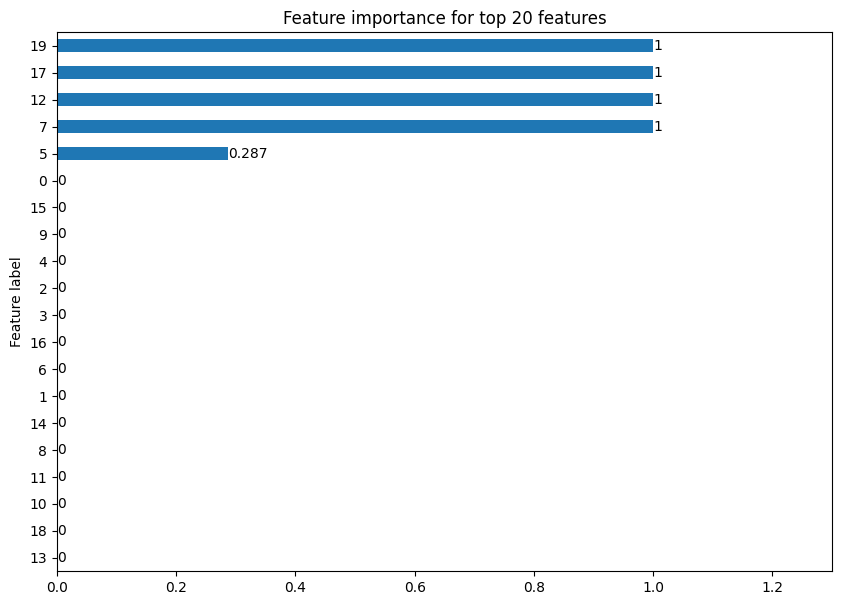

Explanation for graph StamF_Mod.15.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 6.9462e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7253e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


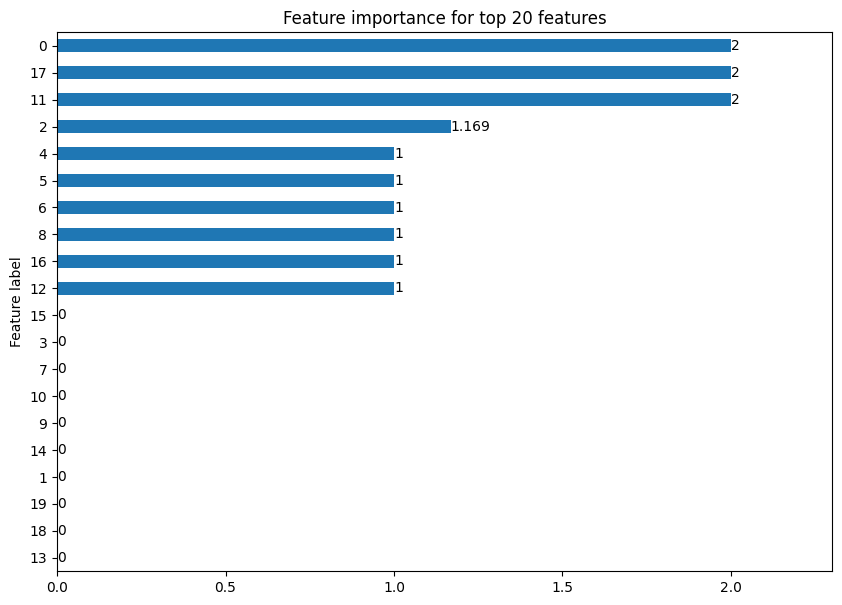

Explanation for graph idmO_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7464e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


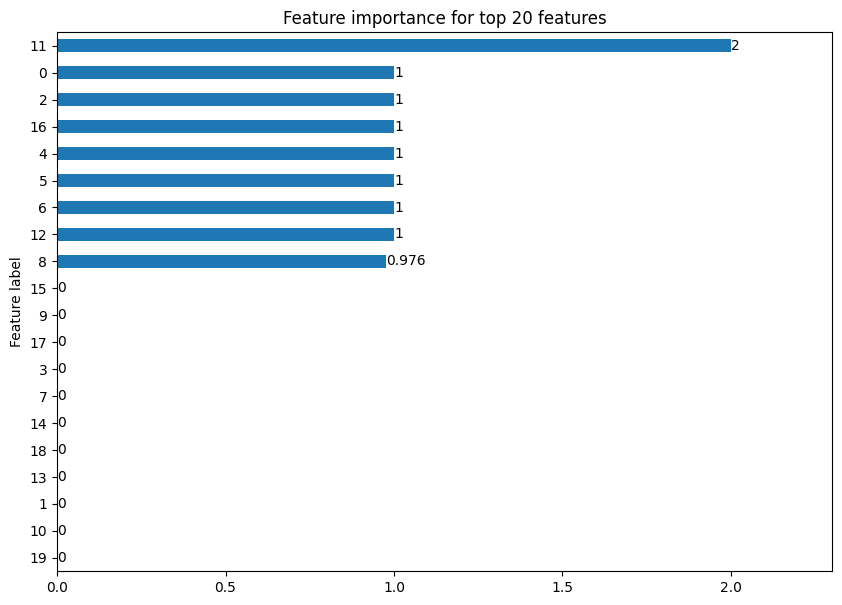

Explanation for graph nemA4_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


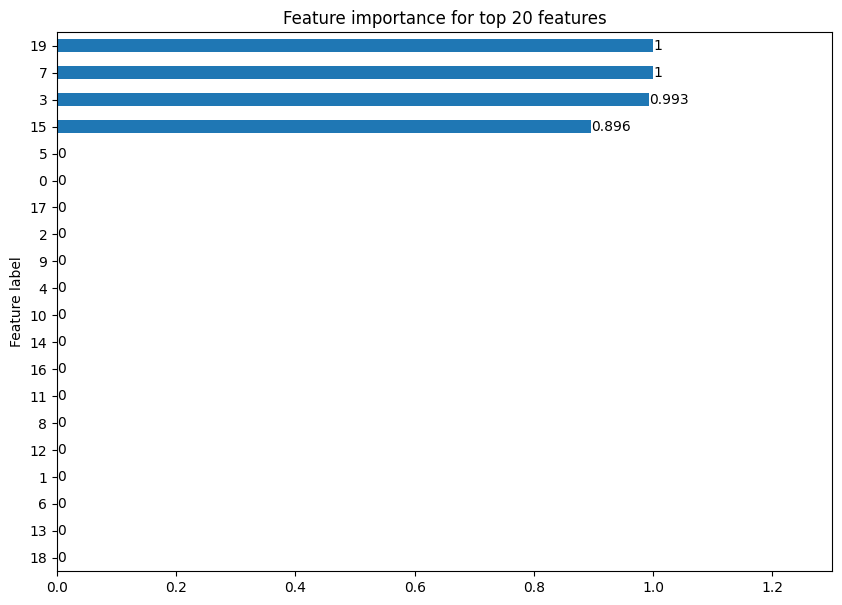

Explanation for graph nysB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0245e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


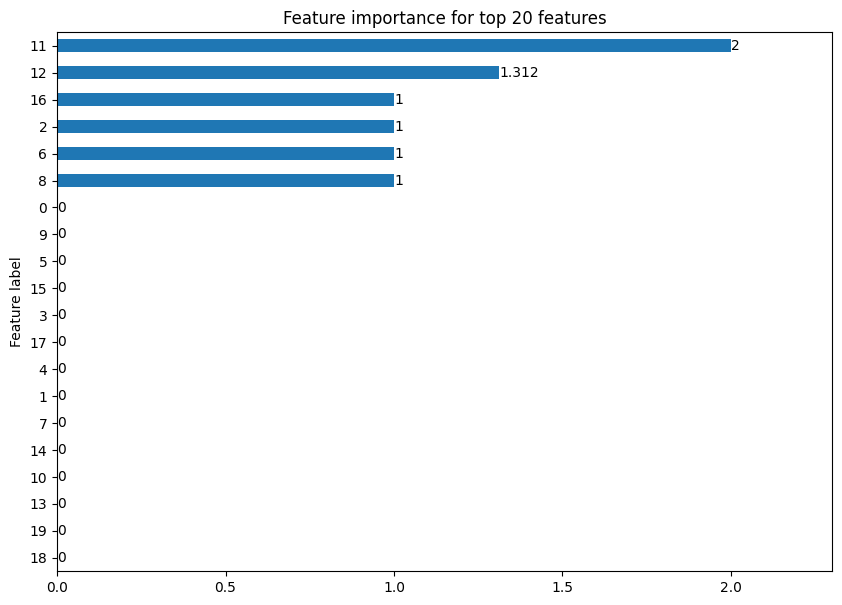

Explanation for graph gfsA_Mod.5.pdb_aligned: tensor([6.2583e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9188e-10, 0.0000e+00,
         0.0000e+00],
        [4.9654e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


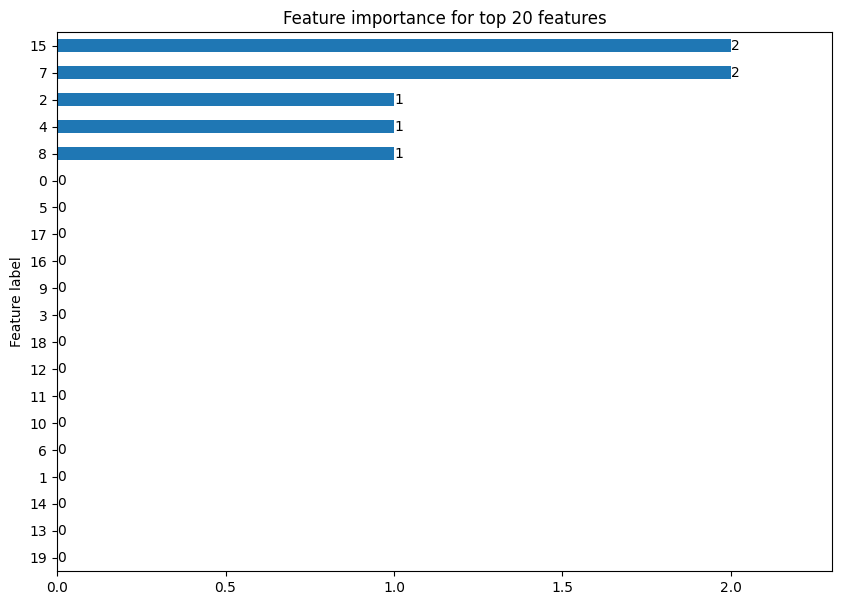

Explanation for graph asmD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


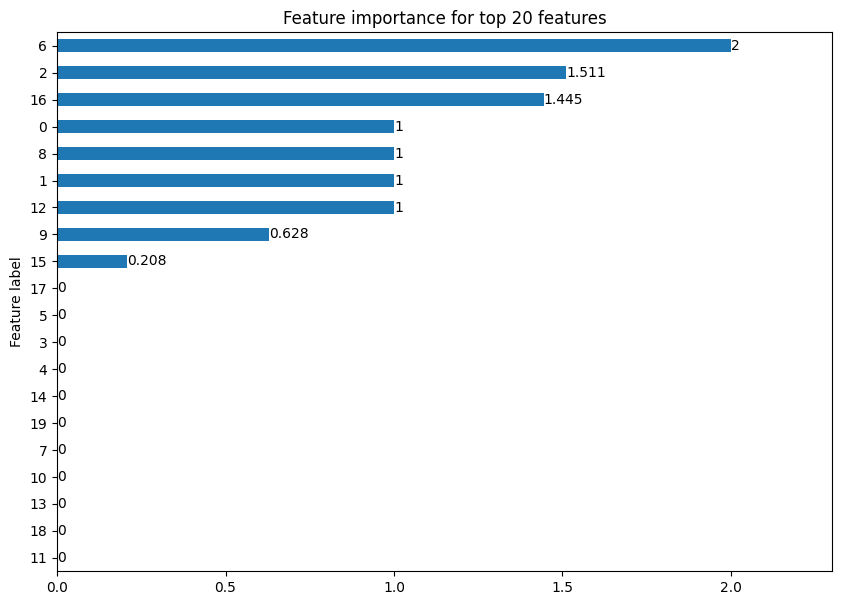

Explanation for graph npmE_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9013e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


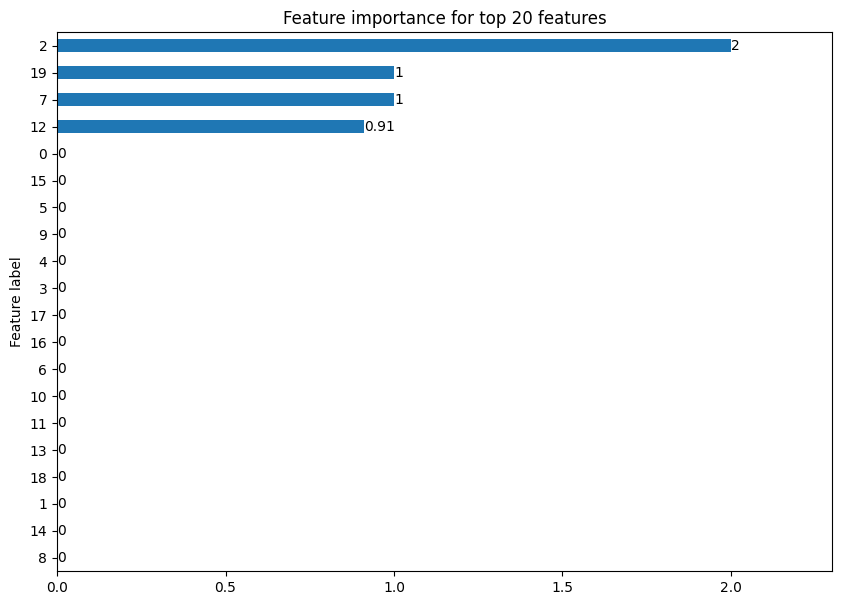

Explanation for graph pimS2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


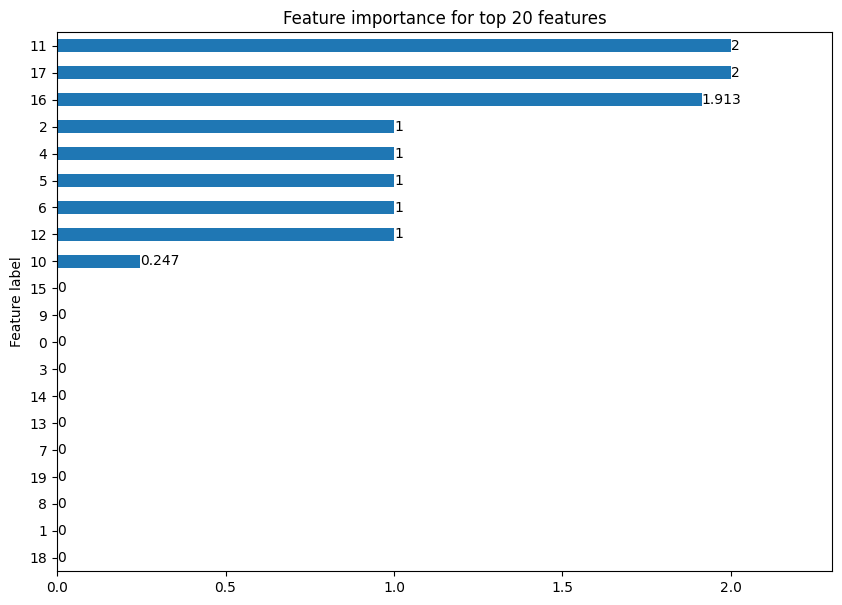

Explanation for graph sfaI_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


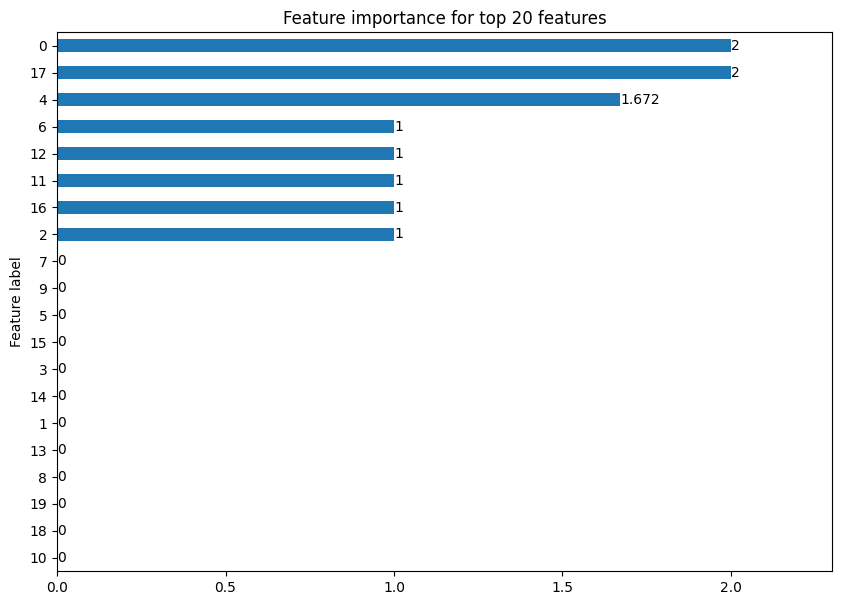

Explanation for graph AceP6_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


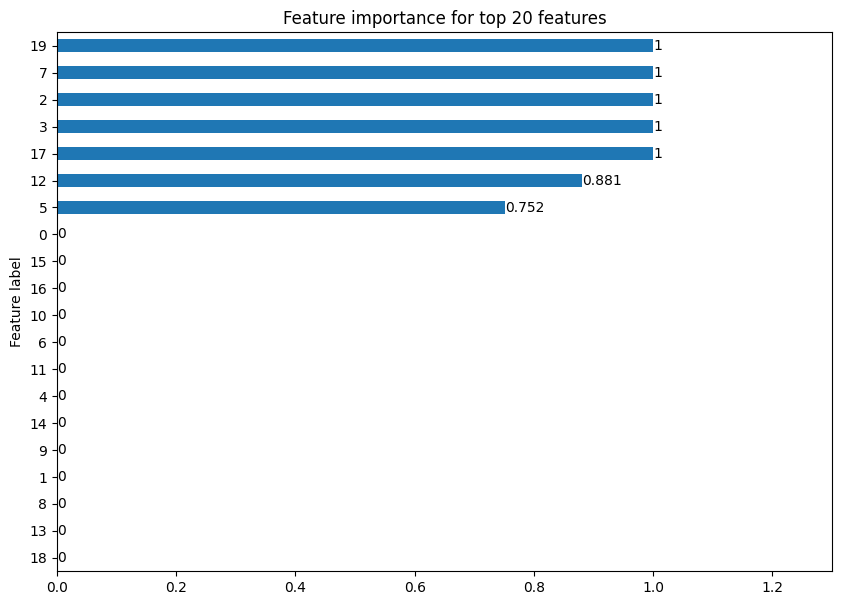

Explanation for graph StamC_Mod.10.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


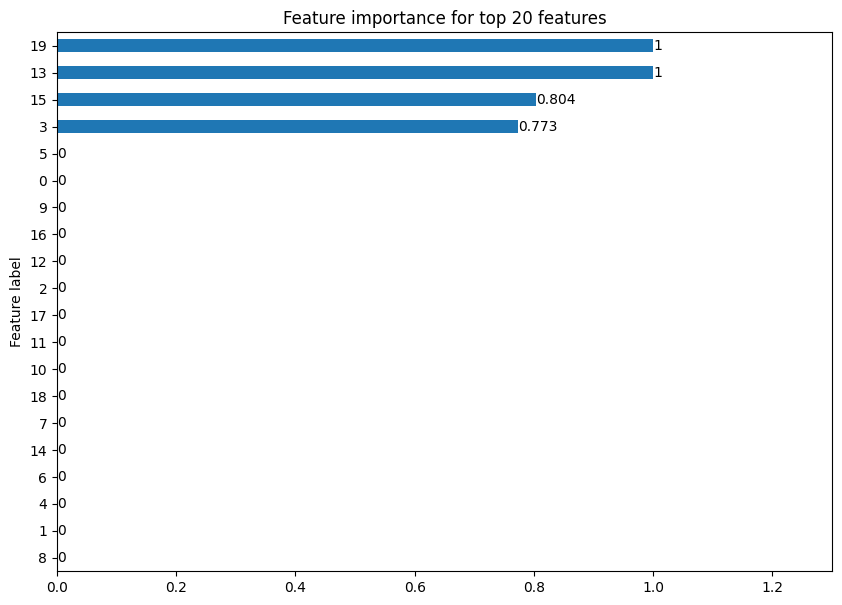

Explanation for graph fosD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3846e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


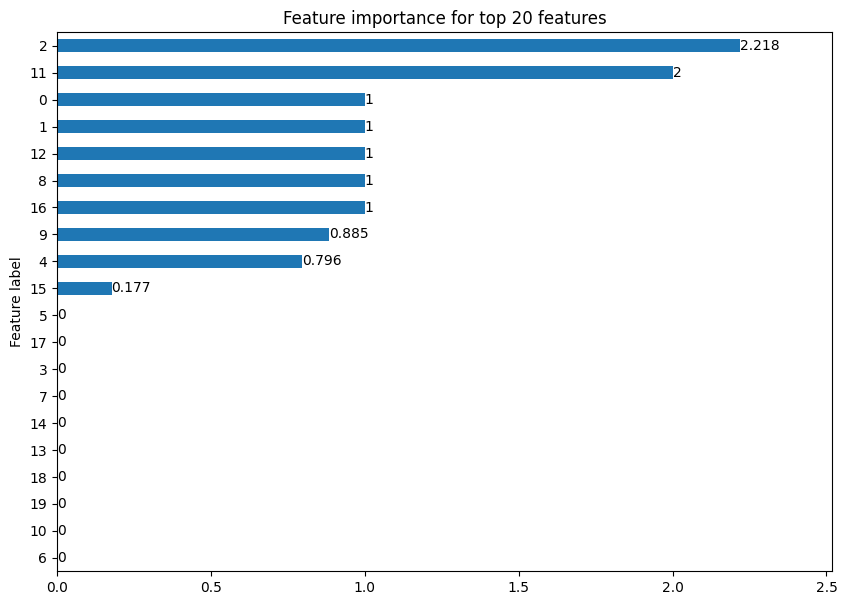

Explanation for graph lasAIII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7360e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


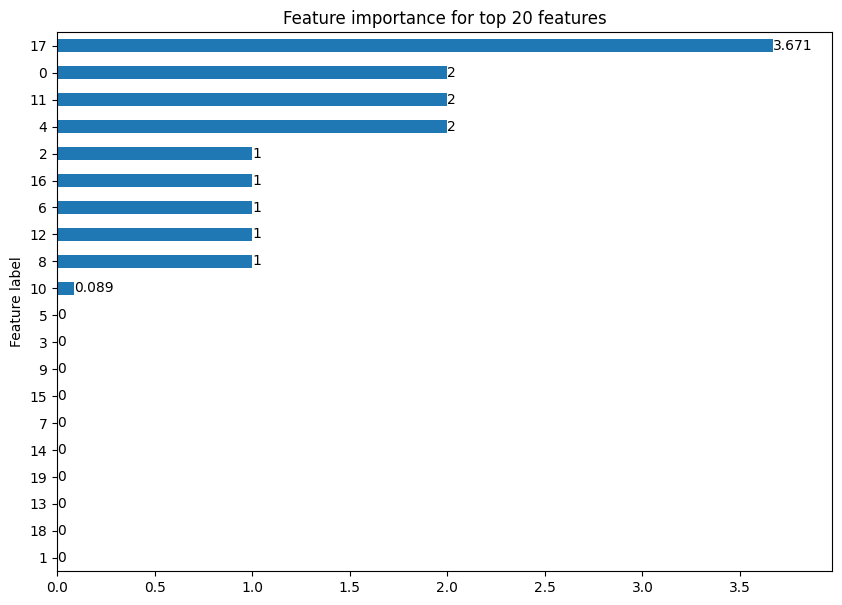

Explanation for graph ChlA5_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7249e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


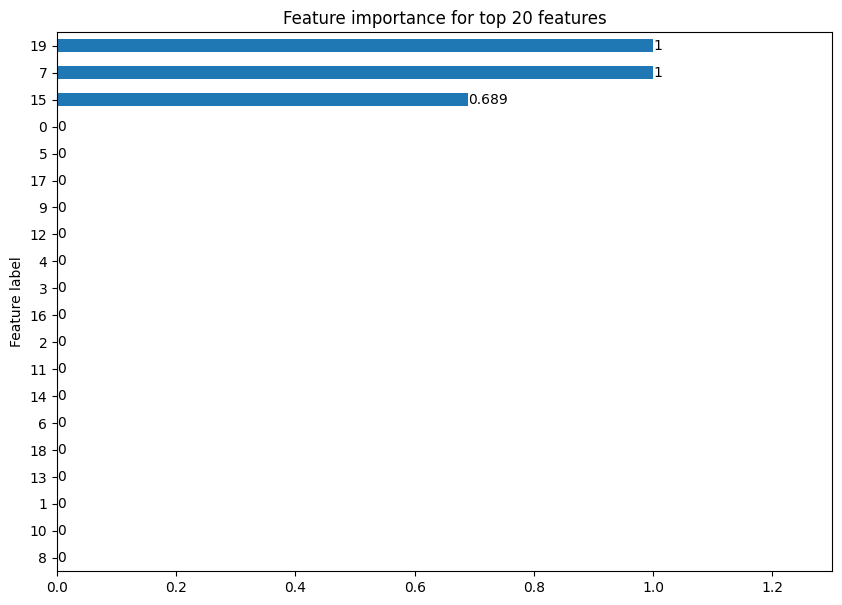

Explanation for graph npmE_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9109e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


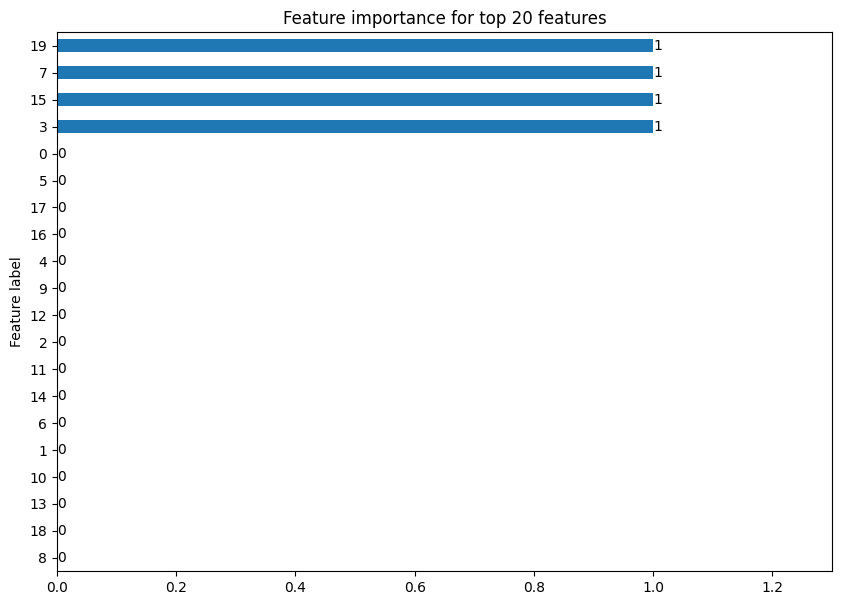

Explanation for graph nemA1-2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


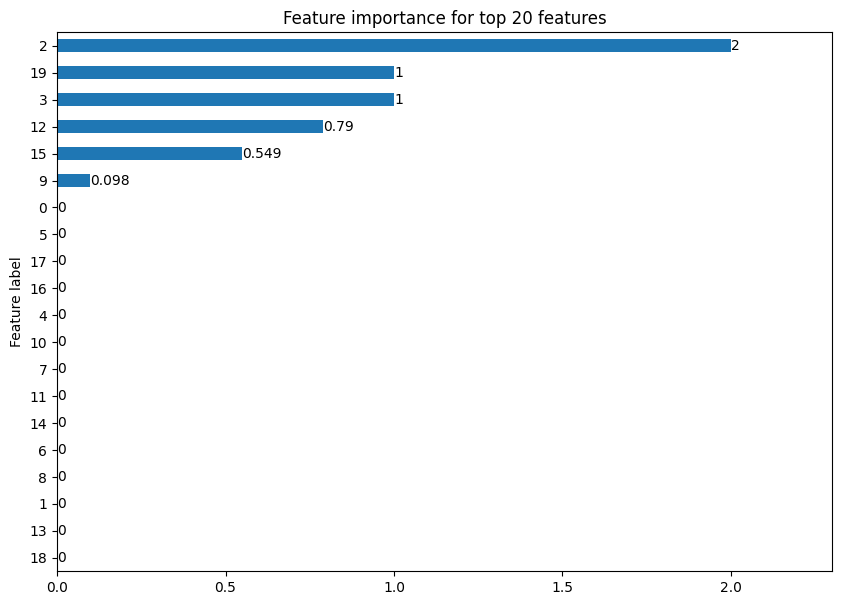

Explanation for graph lipPks2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8534e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


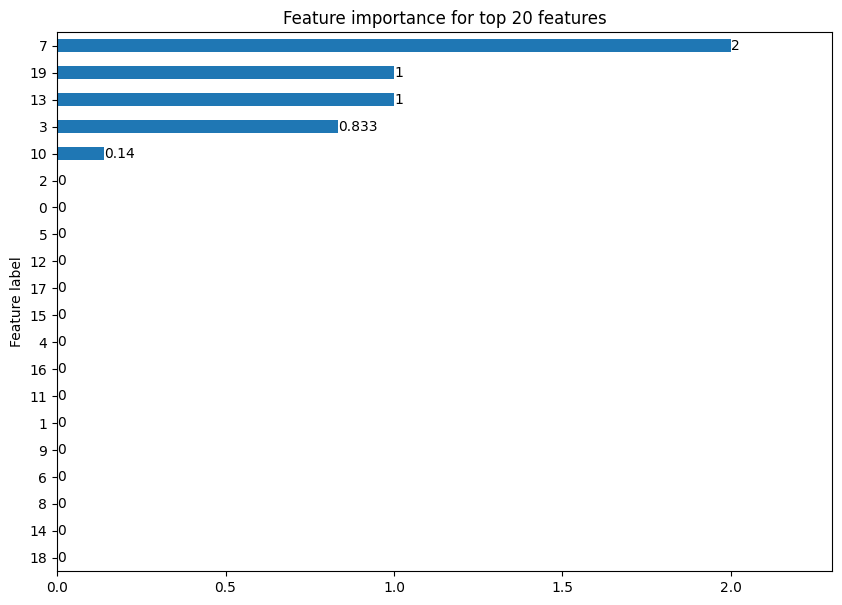

Explanation for graph spnC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0240e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


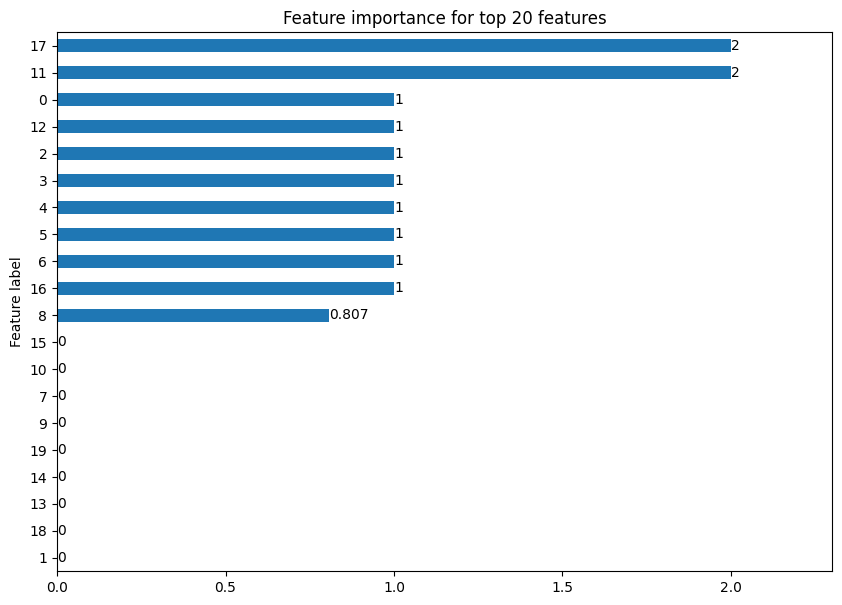

Explanation for graph zinB_Mod.3.pdb_aligned: tensor([5.6196e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6745e-10, 0.0000e+00,
         0.0000e+00],
        [4.6836e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


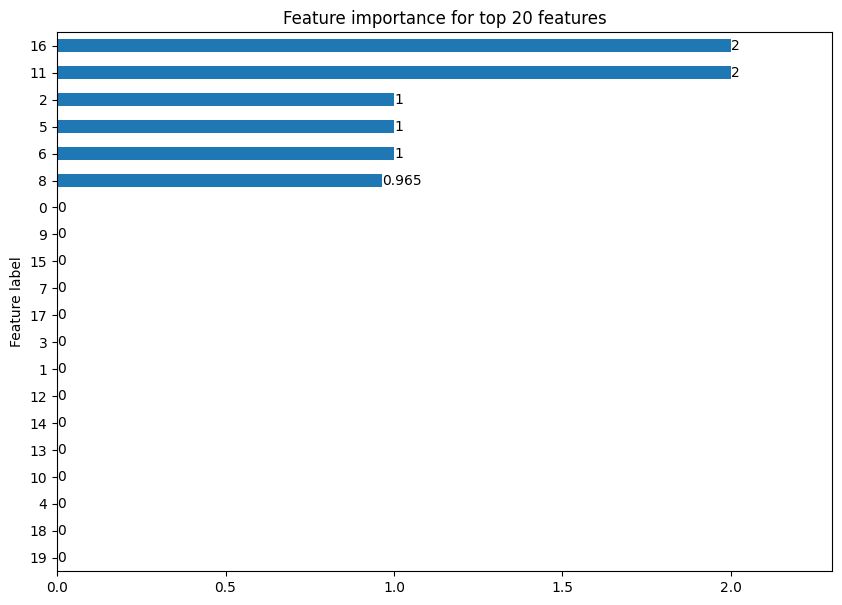

Explanation for graph revD_Mod.4.pdb_aligned: tensor([6.7456e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0753e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


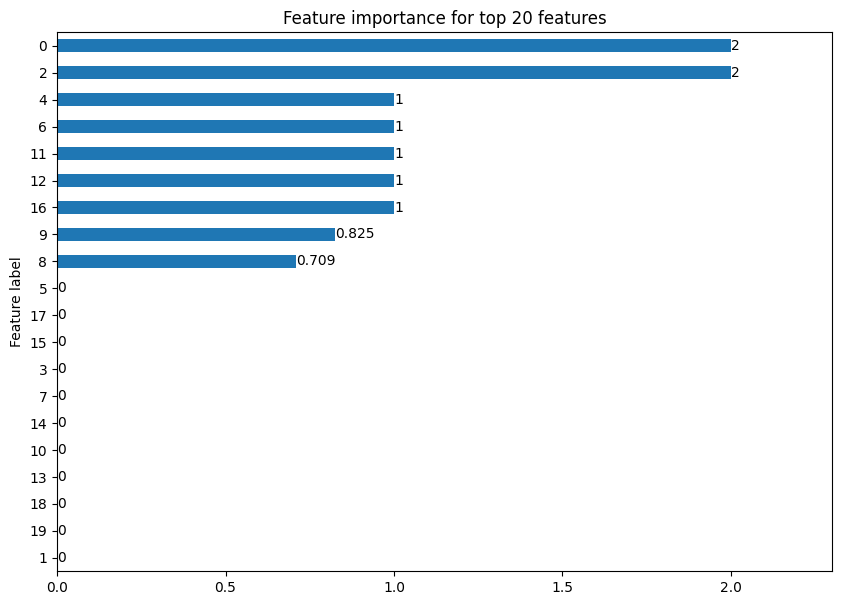

Explanation for graph zinE_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


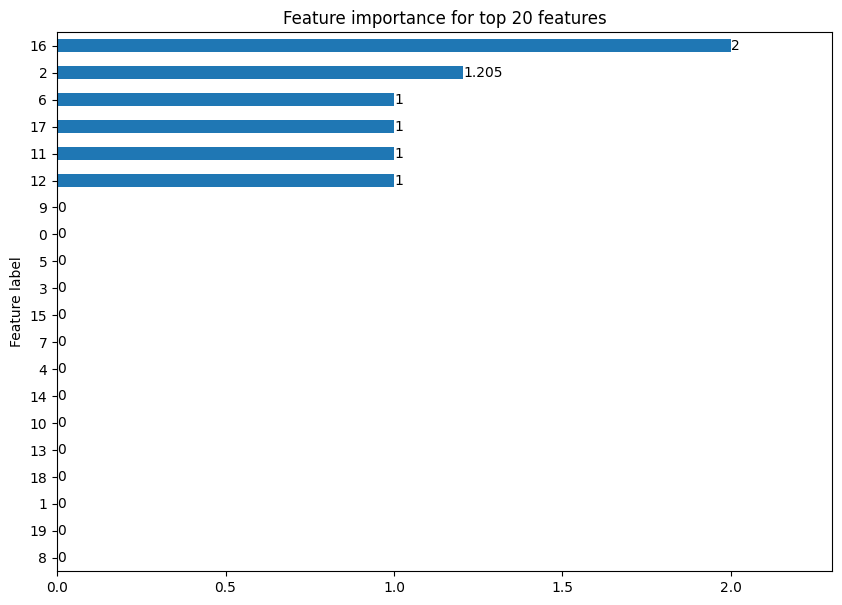

Explanation for graph idnP3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9413e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


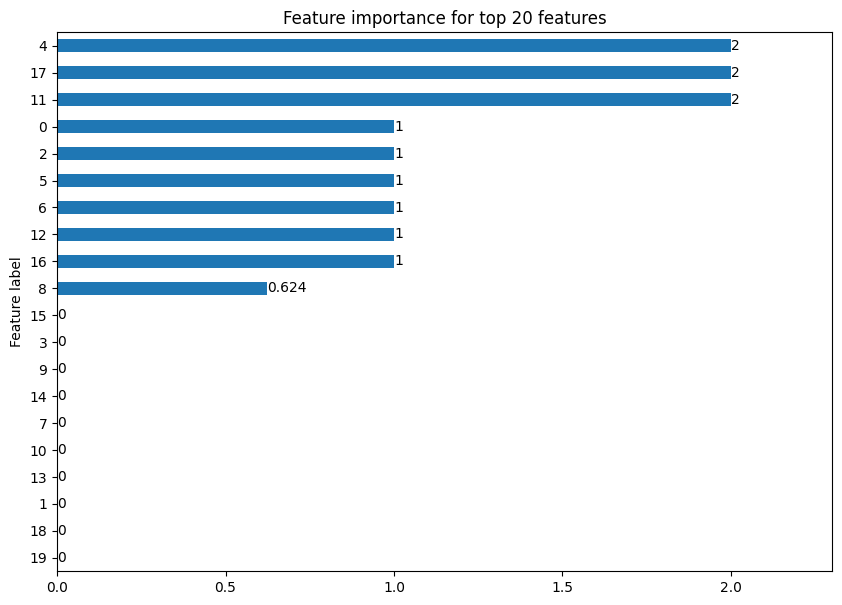

Explanation for graph StamH_Mod.19.pdb_aligned: tensor([6.7732e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[8.2978e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.3292e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.3296e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


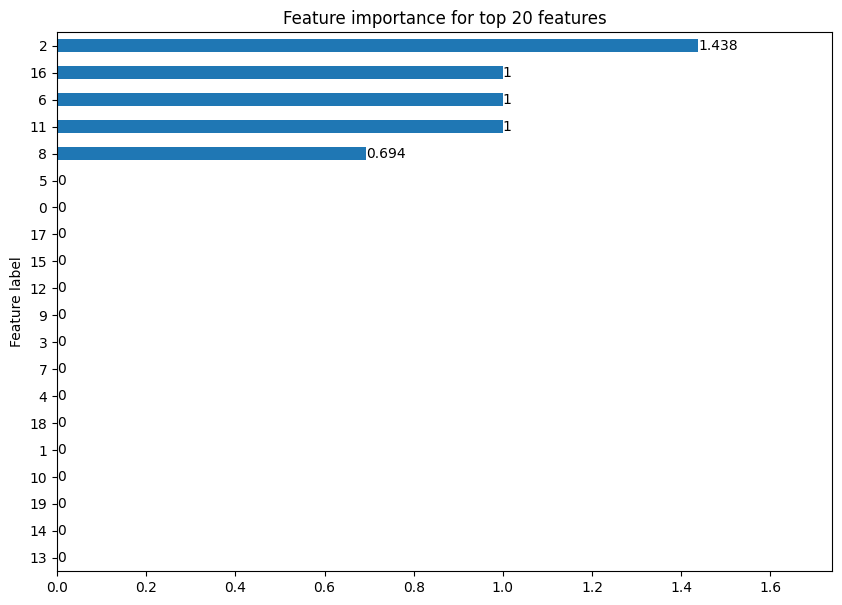

Explanation for graph nanA8_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


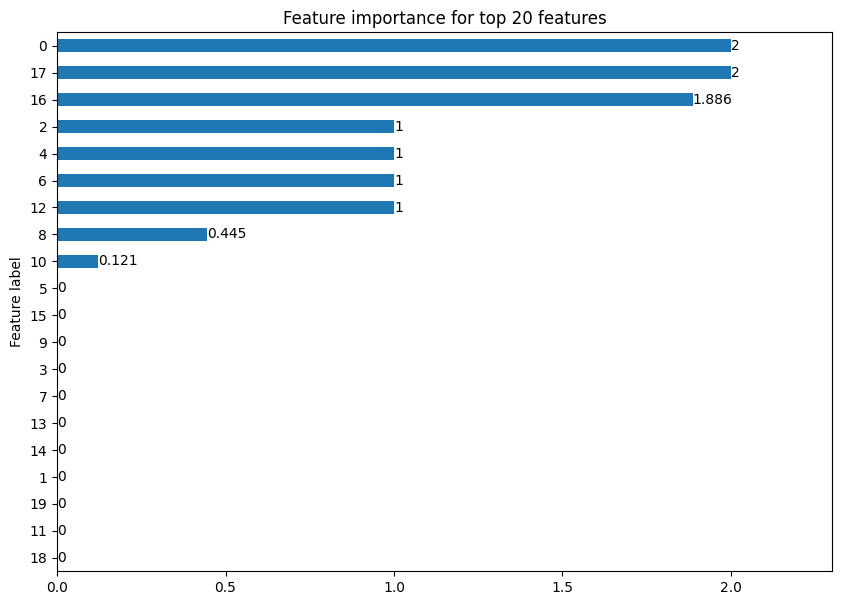

Explanation for graph azlB_Mod.2.pdb_aligned: tensor([7.9228e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3316e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


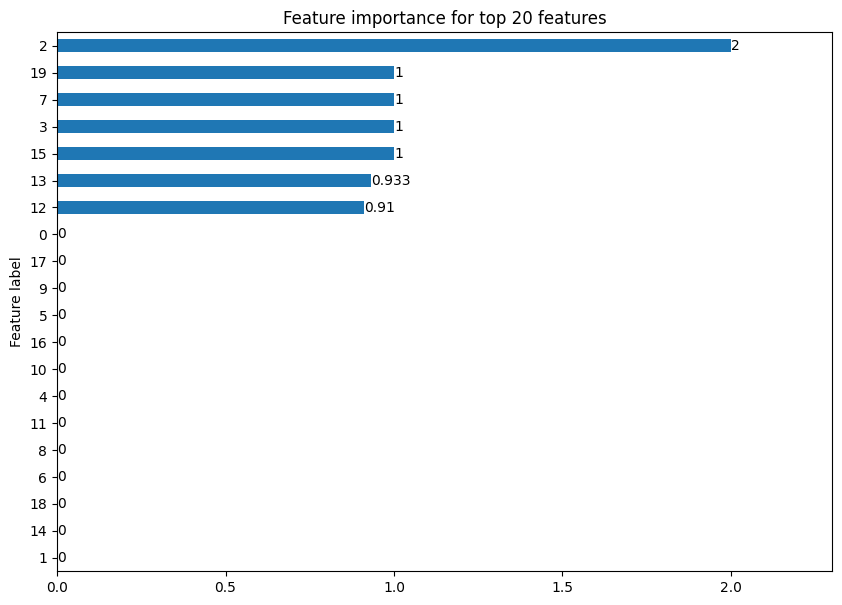

Explanation for graph almHV_Mod.8.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8571e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


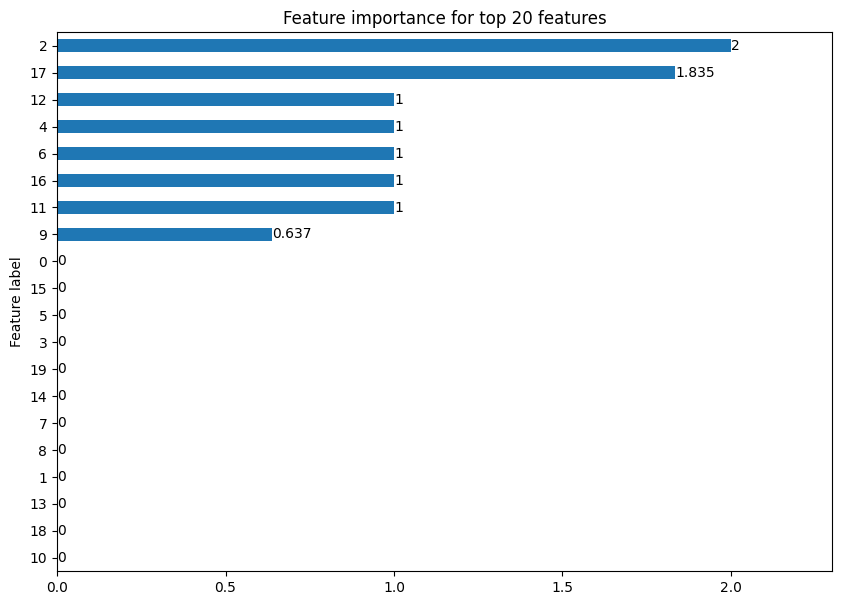

Explanation for graph chmGV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


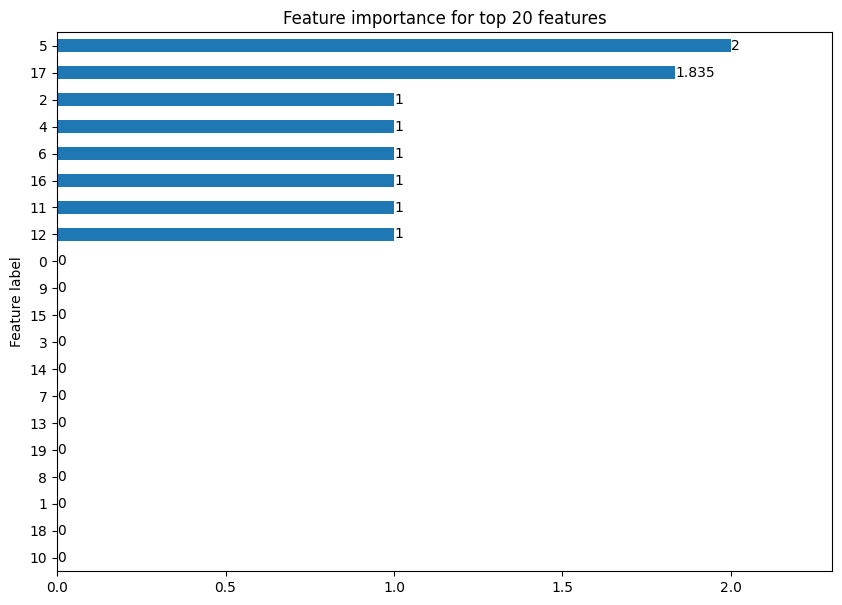

Explanation for graph nysJ_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


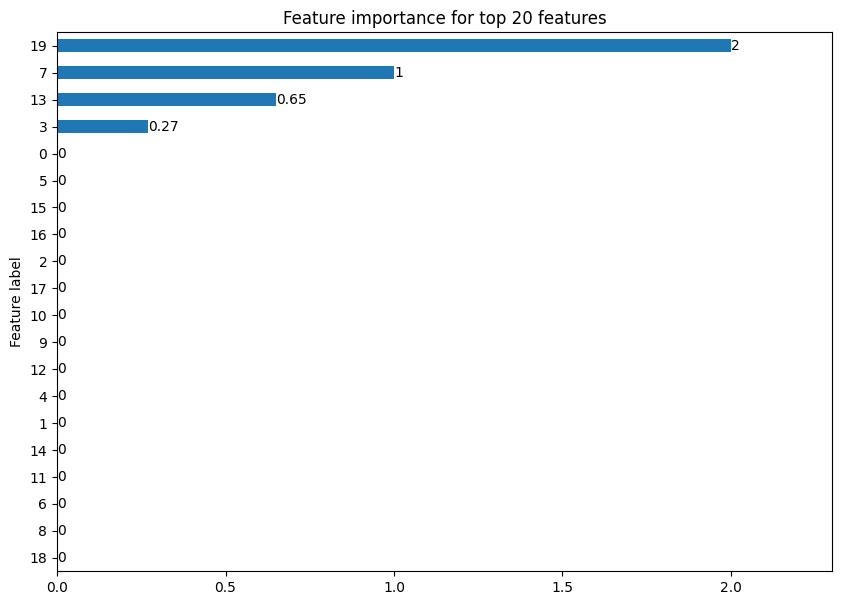

Explanation for graph tiaA1_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.8787e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


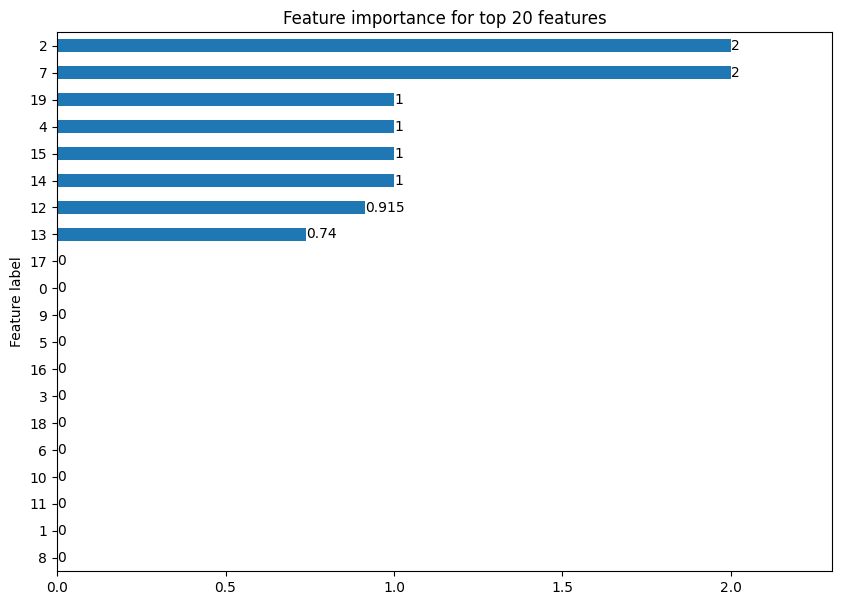

Explanation for graph acuAVI_Mod.5.pdb_aligned: tensor([7.0135e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6257e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


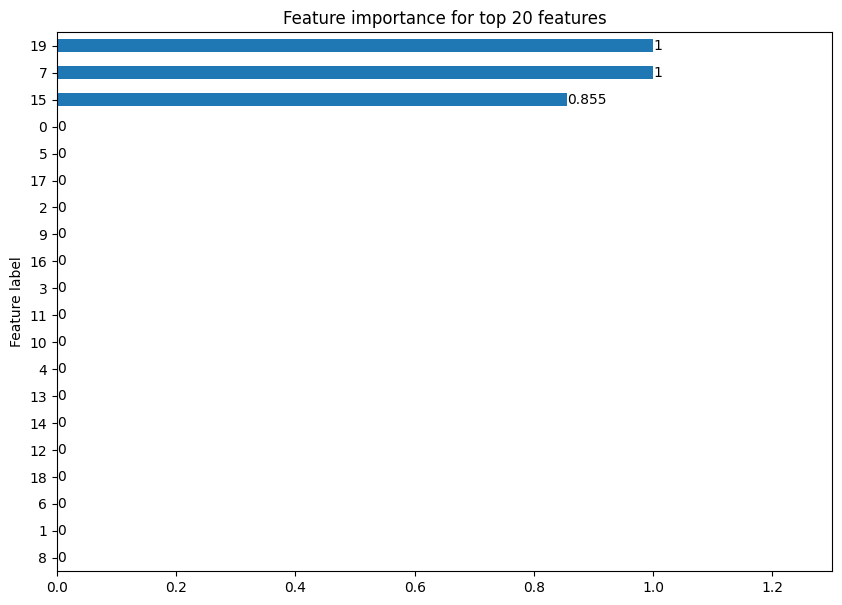

Explanation for graph mlsA1_Mod.7.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9912e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


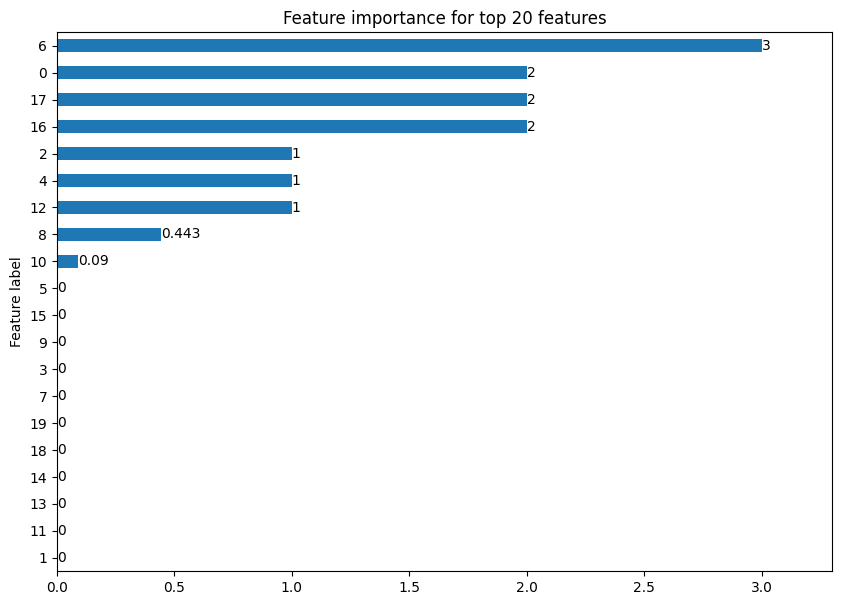

Explanation for graph pteA1_Mod.2.pdb_aligned: tensor([7.4612e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.5571e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


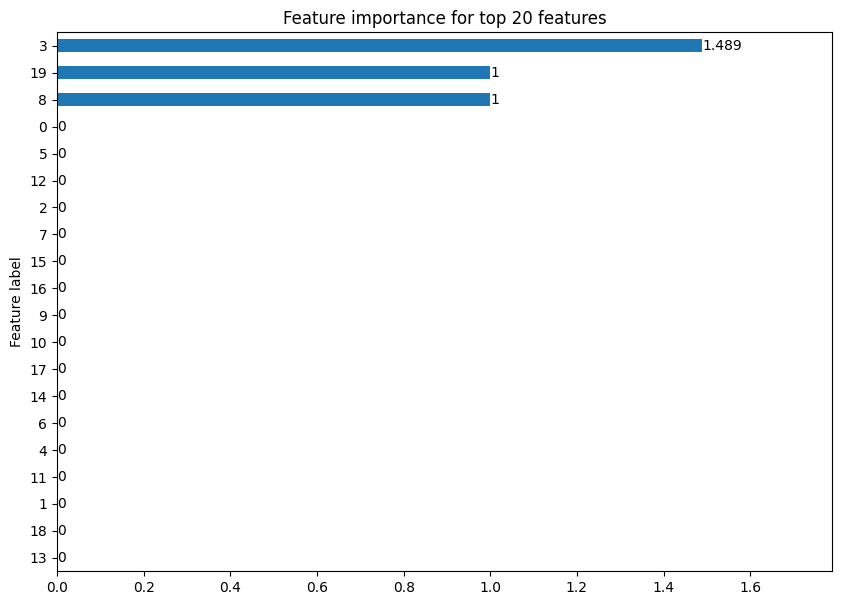

Explanation for graph acuAV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8185e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.8165e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


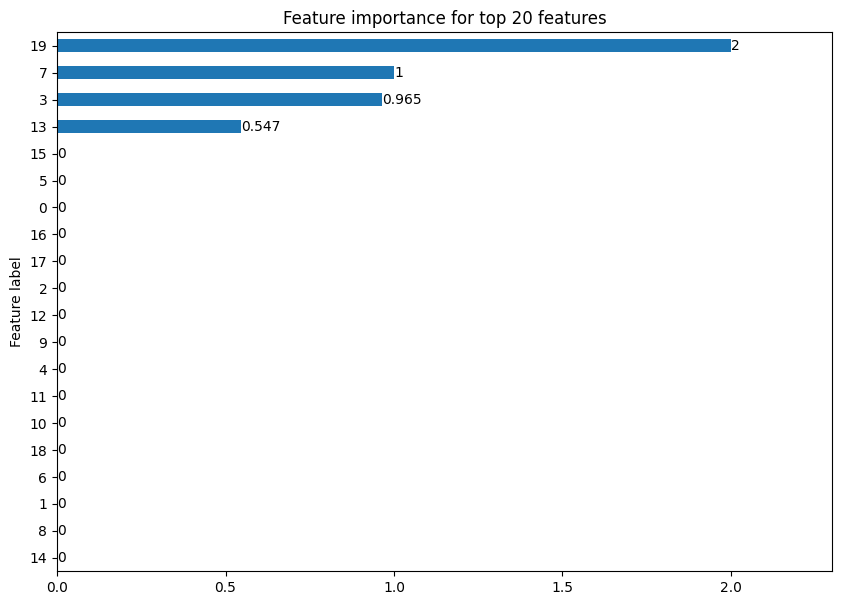

Explanation for graph npmC_Mod.3.pdb_aligned: tensor([7.5221e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7223e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


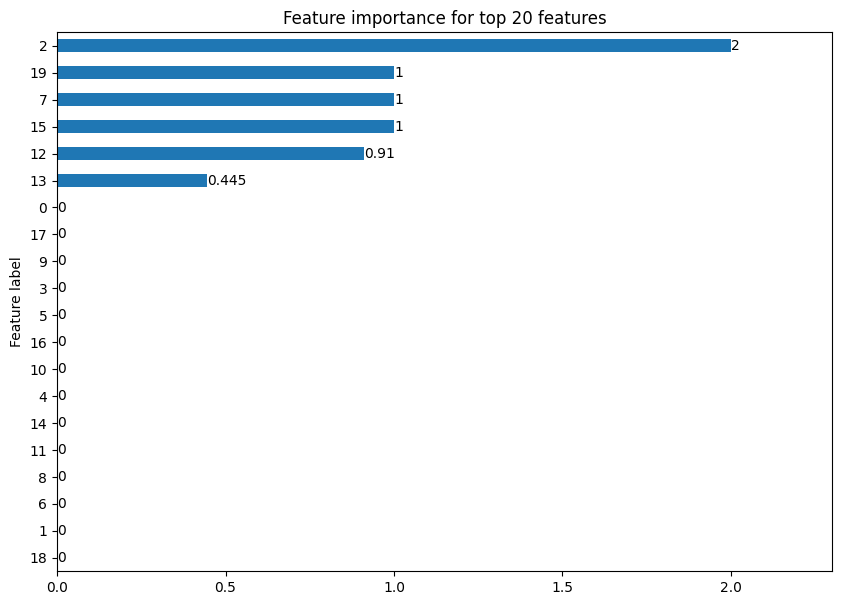

Explanation for graph acuAVI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


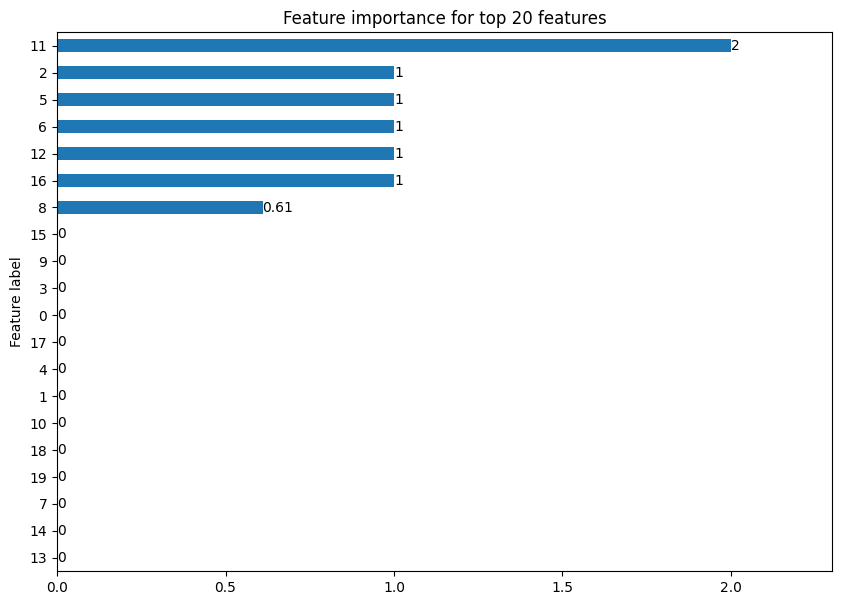

Explanation for graph pteA4_Mod.4.pdb_aligned: tensor([8.4925e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.4505e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


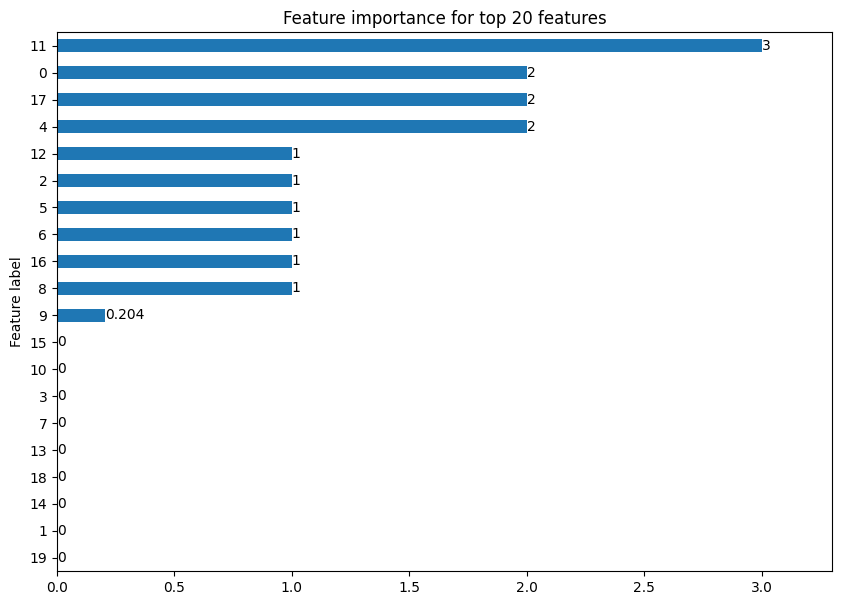

Explanation for graph hlsG_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


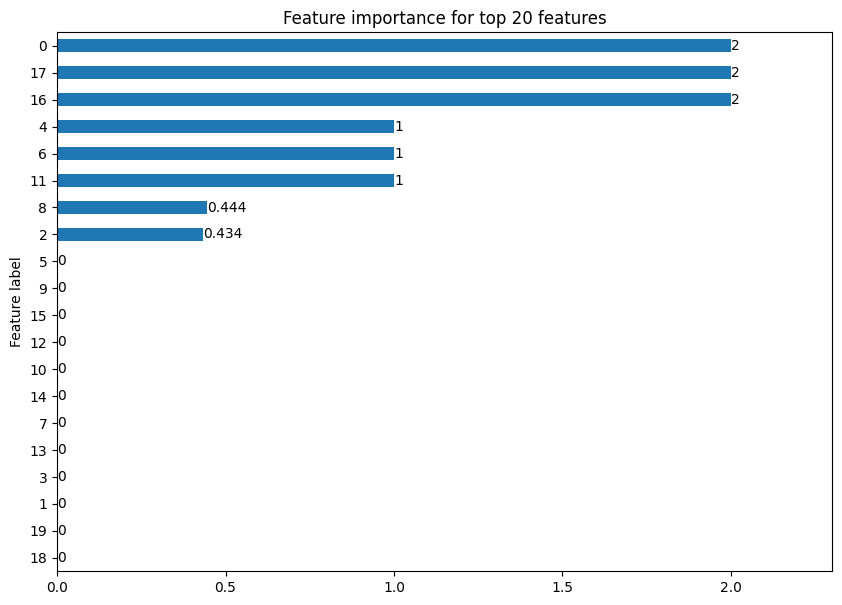

Explanation for graph aizA_mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5944e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


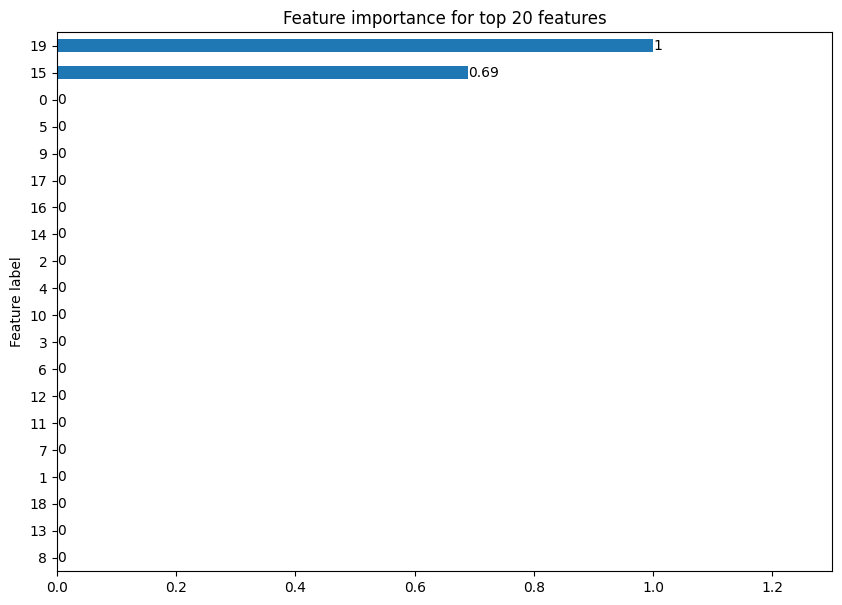

Explanation for graph borA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1934e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


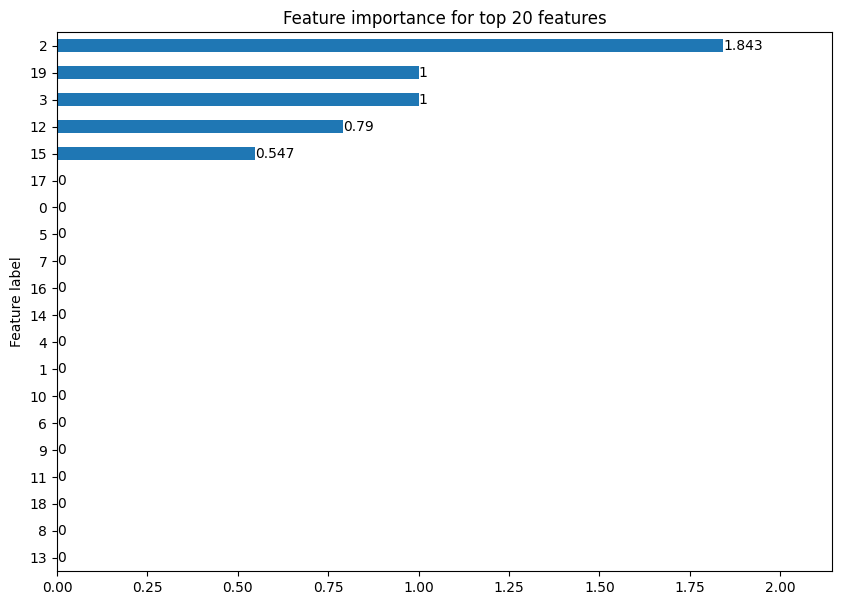

Explanation for graph gerSI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.8375e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


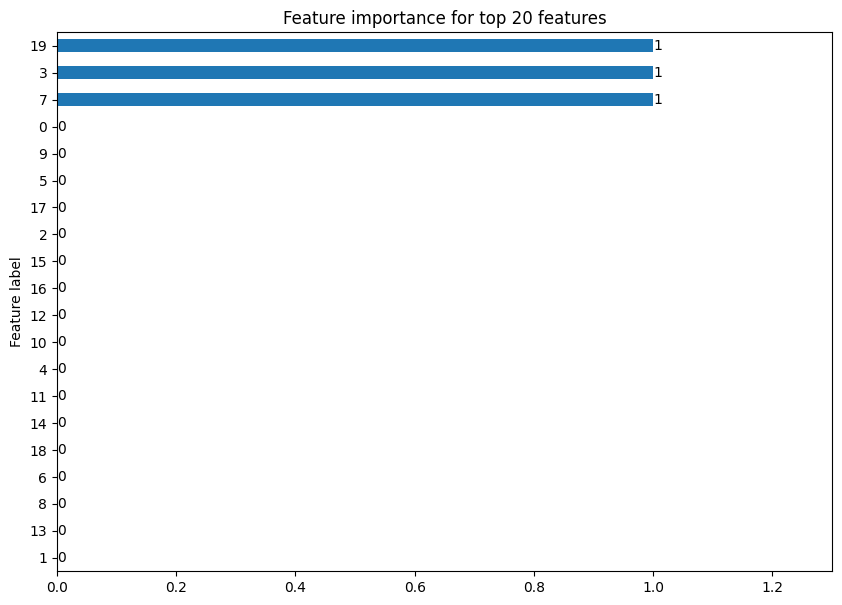

Explanation for graph rapA_Mod.3.pdb_aligned: tensor([5.2181e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.6024e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


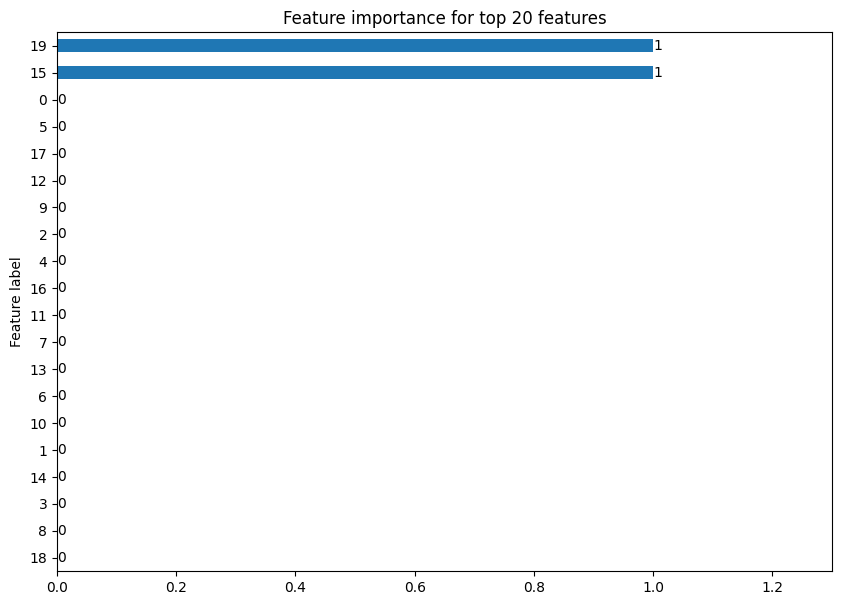

Explanation for graph natD_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.9972e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


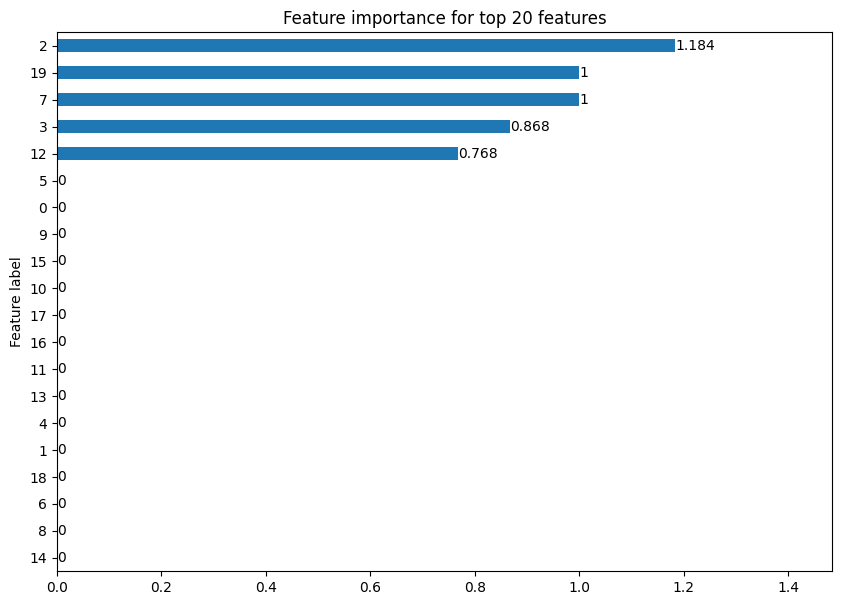

Explanation for graph lasAV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


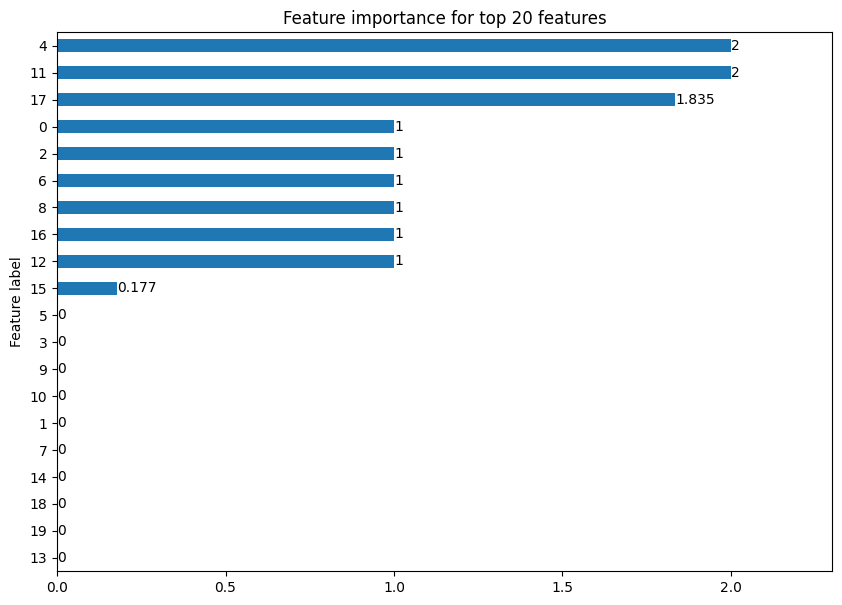

Explanation for graph merC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9283e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


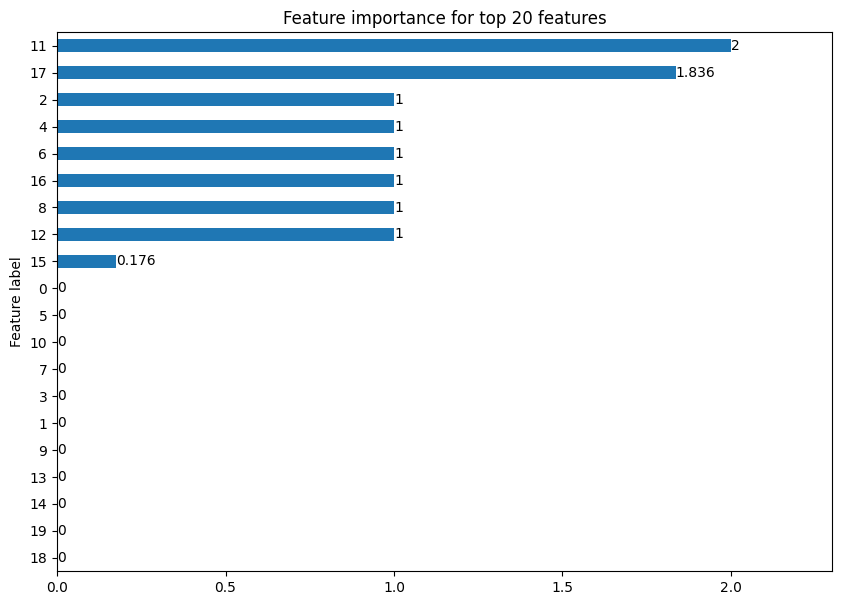

Explanation for graph selB_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


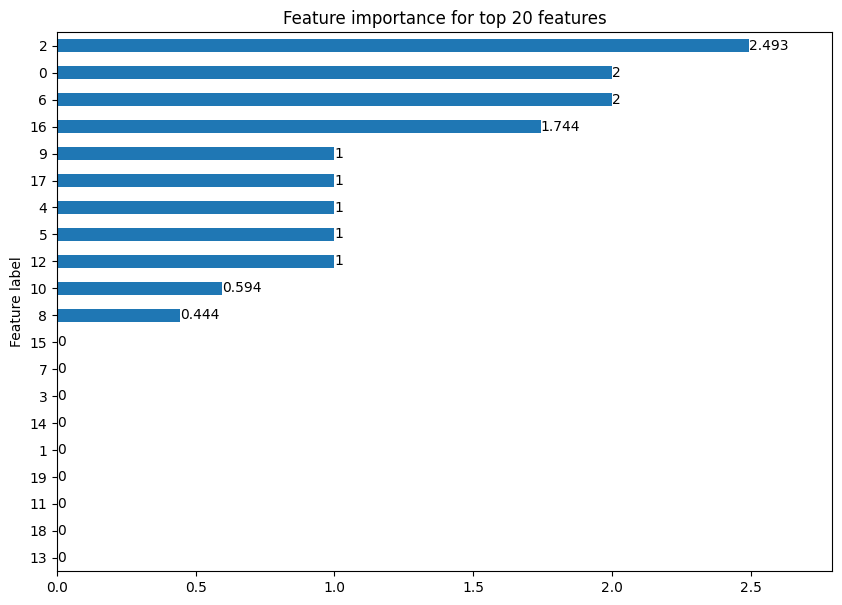

Explanation for graph scnS2_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8412e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


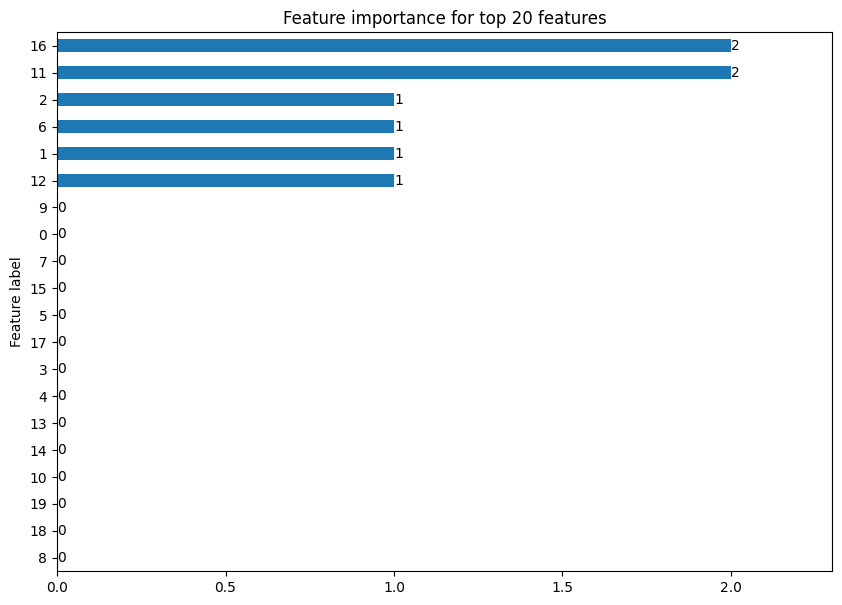

Processing batch with 16 graphs
Explanation for graph slnA4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7667e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


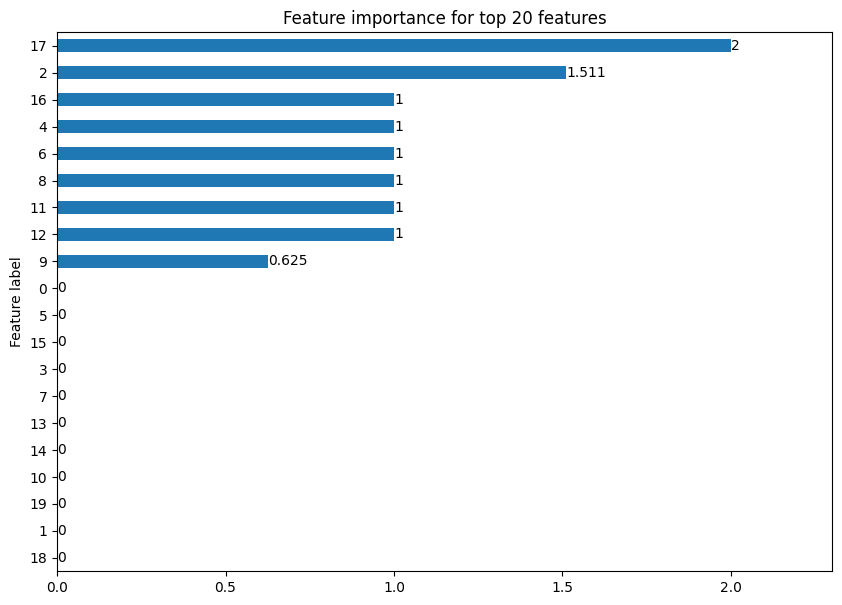

Explanation for graph hbmAII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4259e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


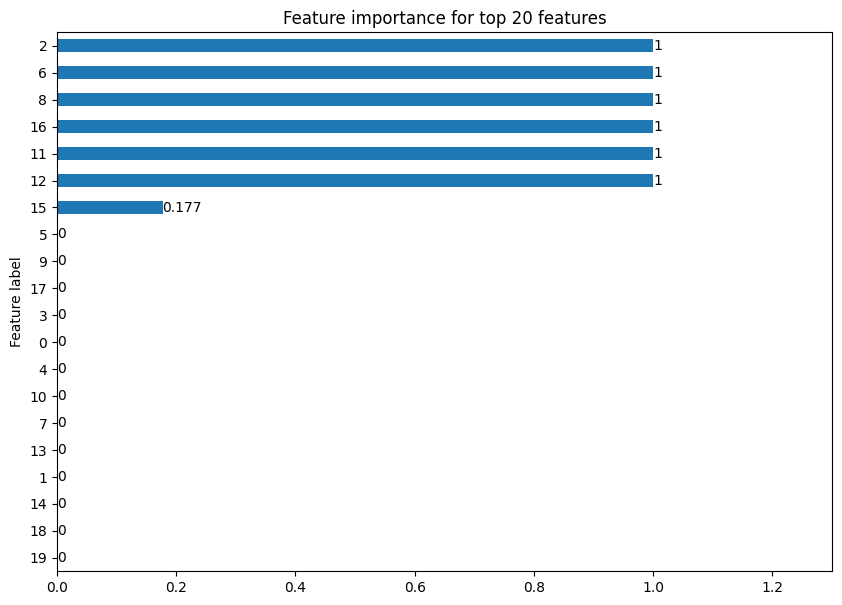

Explanation for graph merC_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


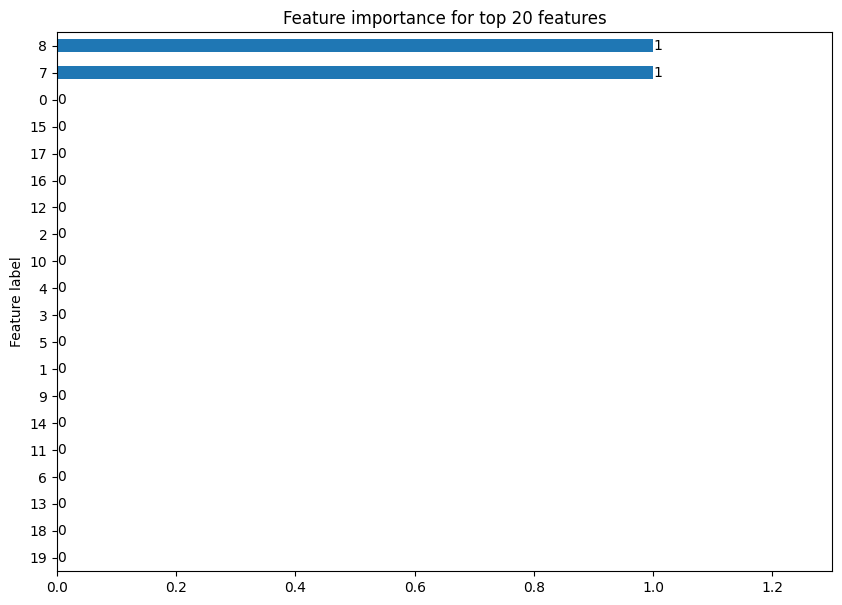

Explanation for graph NcmAIV_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


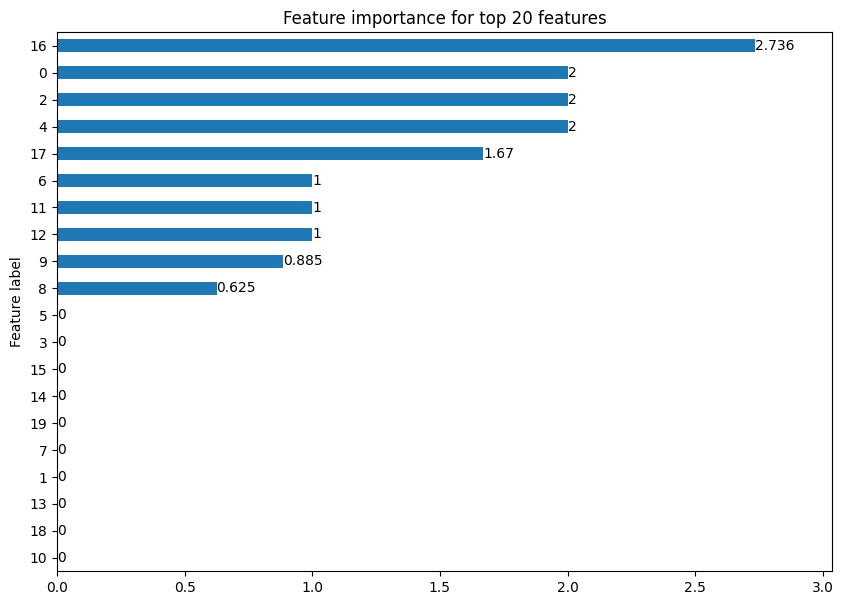

Explanation for graph mycAV_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.8076e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


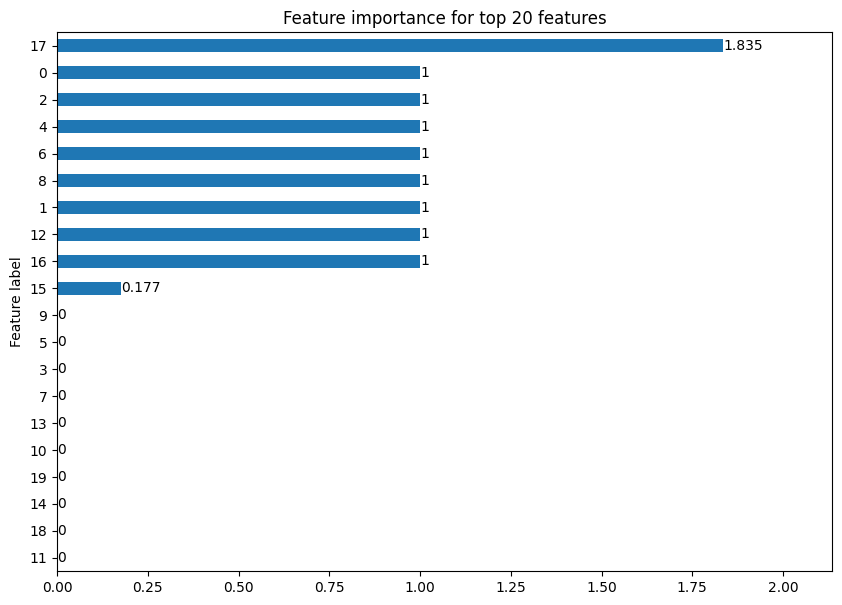

Explanation for graph StamG_Mod.18.pdb_aligned: tensor([0.0000e+00, 8.5501e-11, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[6.6419e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


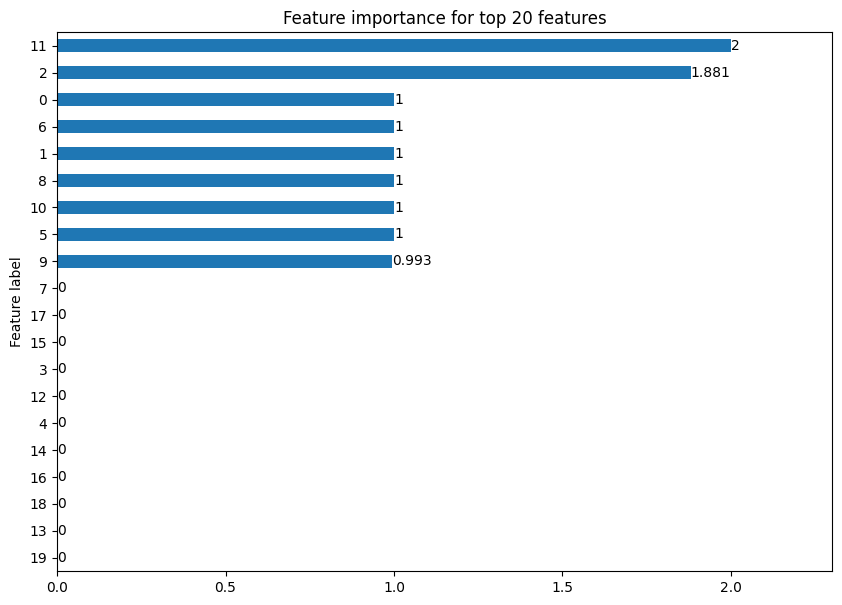

Explanation for graph pldAII_Mod.4.pdb_aligned: tensor([8.2132e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.5887e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


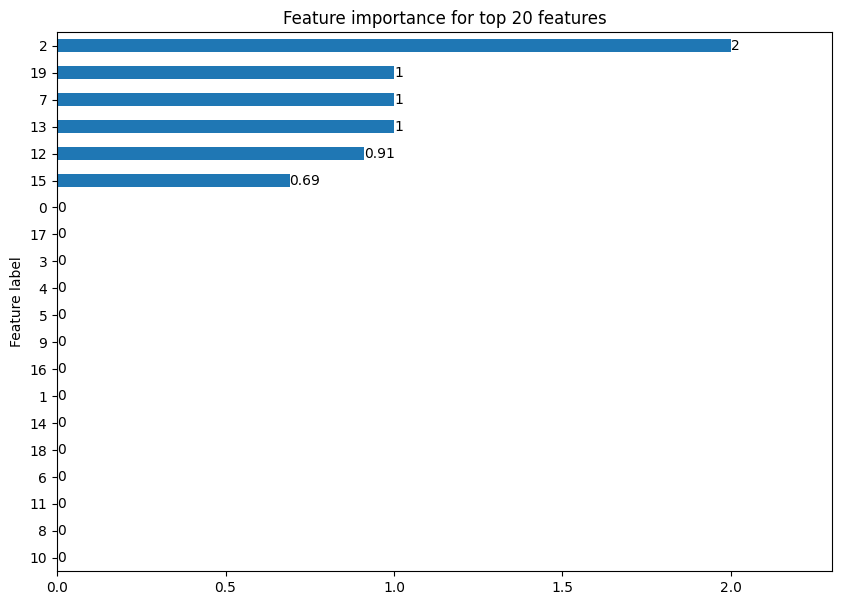

Explanation for graph cle4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0092e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


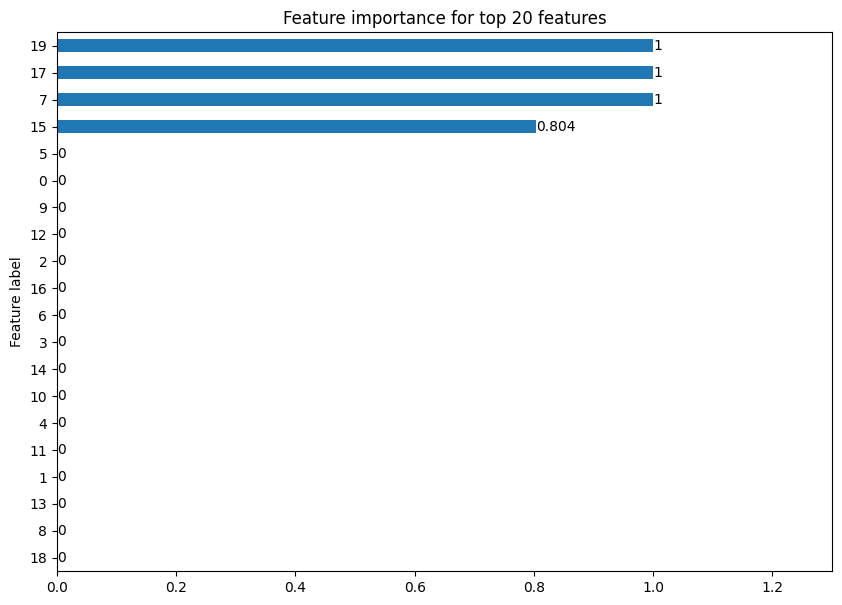

Explanation for graph azlE_Mod.8.pdb_aligned: tensor([7.8486e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7883e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


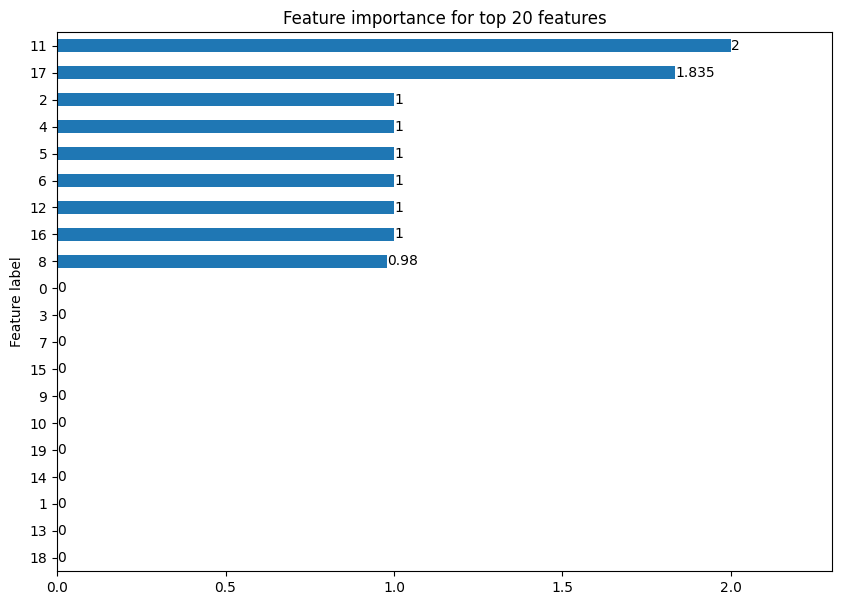

Explanation for graph mlsA1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.5968e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


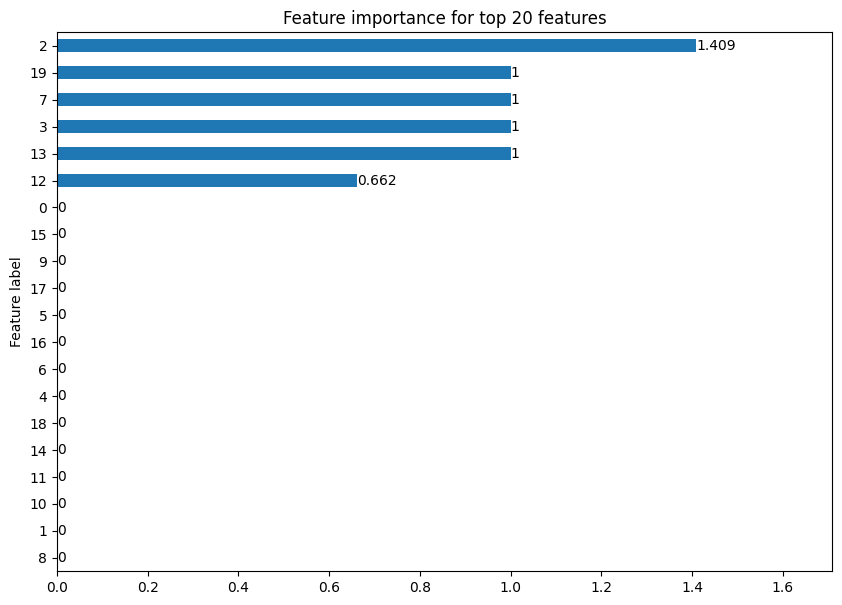

Explanation for graph monAVIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0195e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


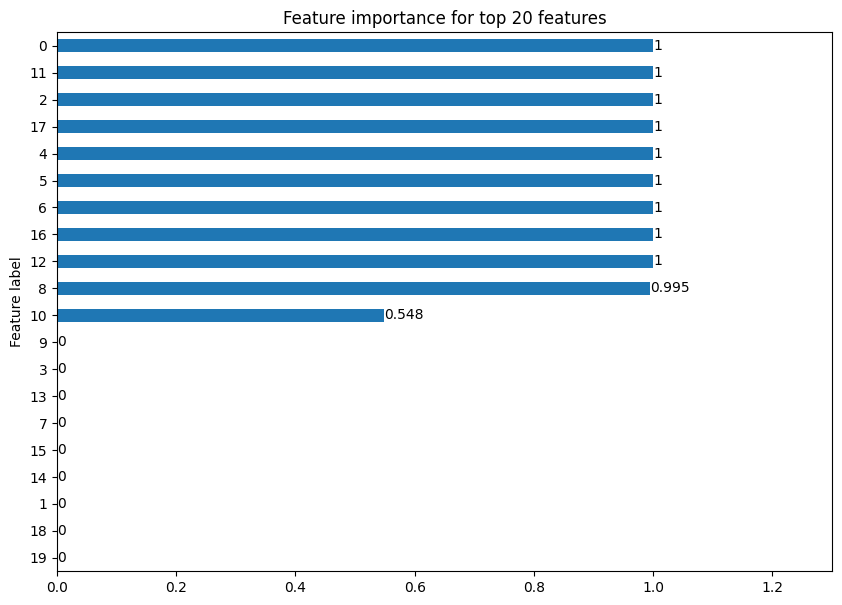

Explanation for graph scnS4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


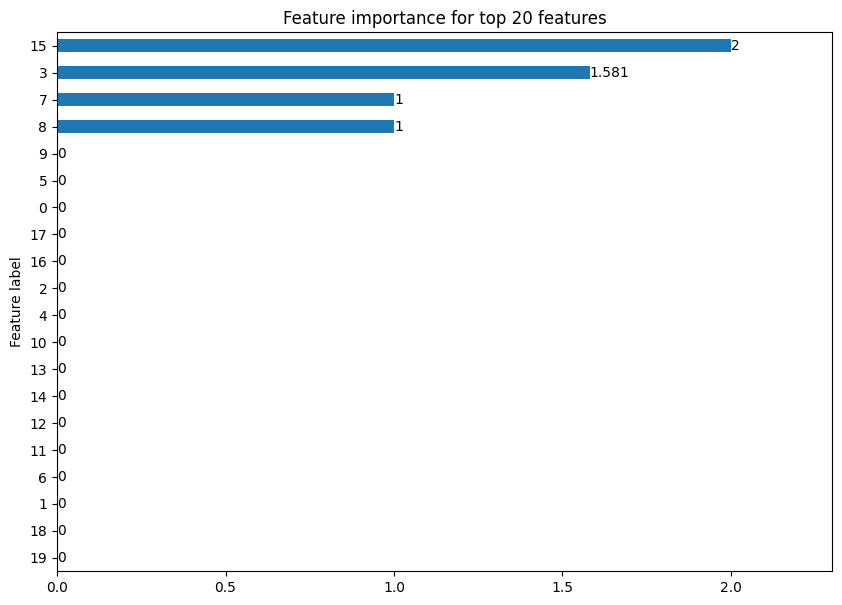

Explanation for graph nysK_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


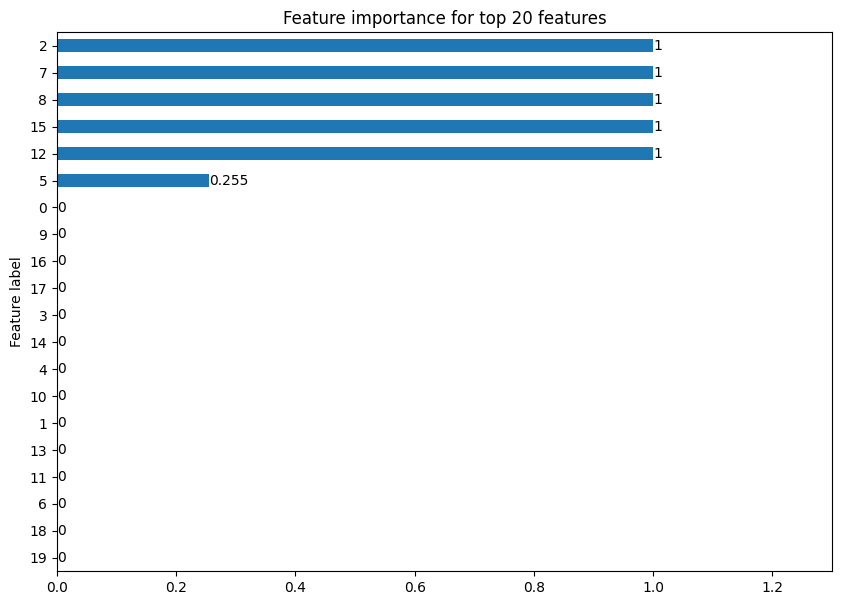

Explanation for graph merC_Mod.5.pdb_aligned: tensor([6.0832e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9472e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


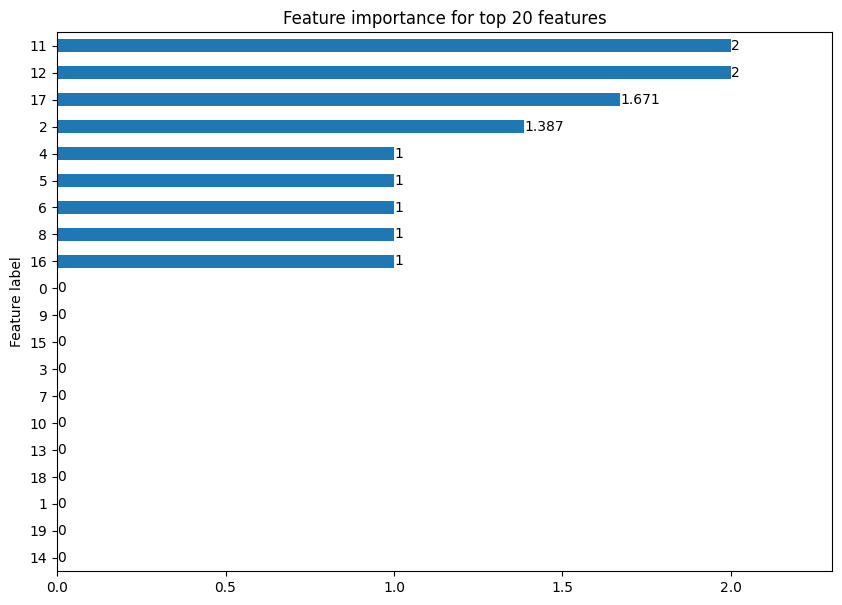

Explanation for graph gfsE_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1125e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


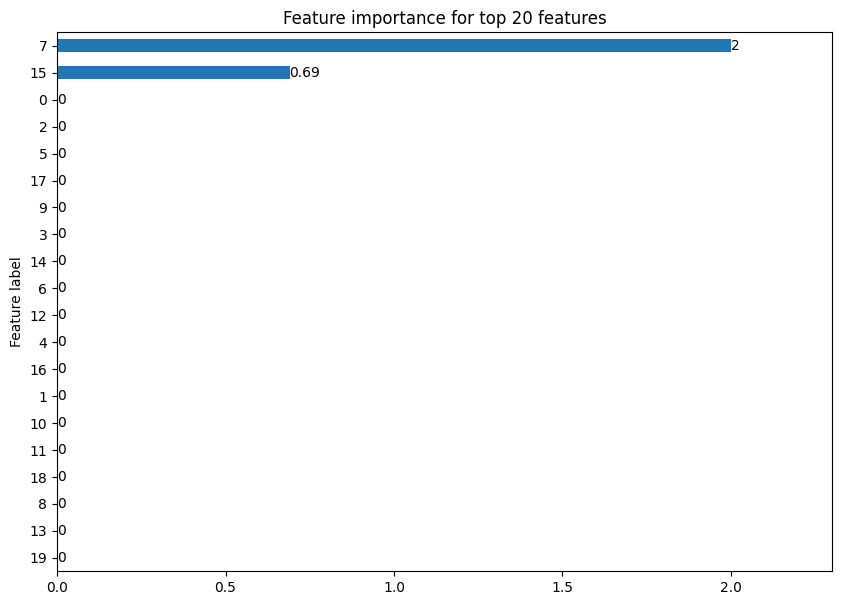

Explanation for graph azlG_Mod.16.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1444e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


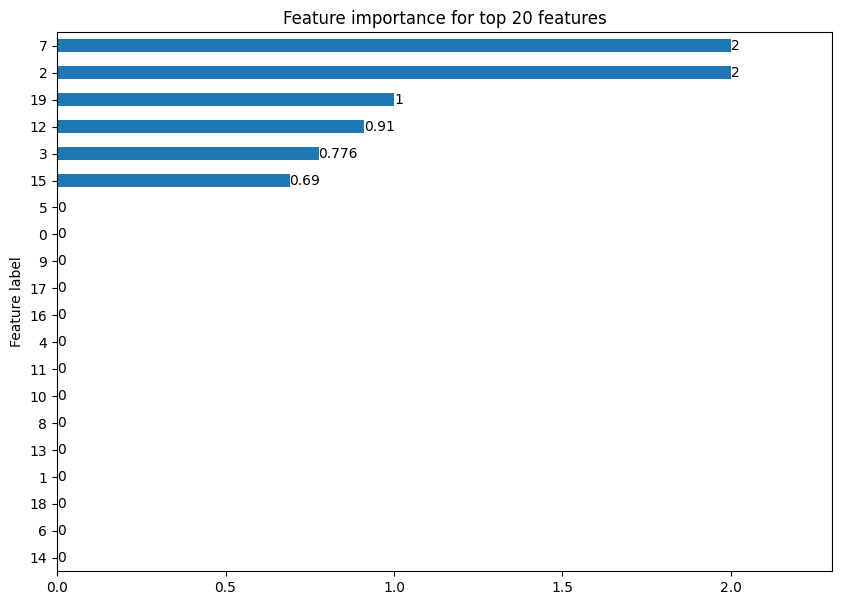

In [60]:
#### Block 5 ####
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd
# Specify the folder where you want to save the output files
output_folder = "Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/03 KS B reduction state binary classifiers/KRa vs KRb metrics"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = val_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader
#loader = val_loader
#for batch in loader:
    # Print some information about the current batch
#    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
 #   for i in range(batch.num_graphs):
  #      # Extract data for the i-th graph in the batch
   #     graph_data = batch[i]
#
 #       # Create a new Data object
  #      data = Data(
   #         edge_index=graph_data.edge_index,
    #        node_id=graph_data.node_id,
     #       coords=graph_data.coords,
      #      name=graph_data.name,
#            num_nodes=graph_data.num_nodes,
 #           x=graph_data.x.view(len(graph_data.node_id), 20),
  #      )
#
 #       # Extract the graph-level label for the current graph
  #      target_values = graph_data.graph_y.tolist()
   #     target = torch.tensor(target_values).float()
#
 ##       # Generate explanation for the node at index `10`:
   #     explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)
#
 #       # Print or do something with the explanation for the current graph
  #      print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)
#
 #       # Optionally, you can visualize the feature importance for each graph
 #       explanation.visualize_feature_importance(top_k=20)
#
 #       # Save the output of visualize_graph to a file in the specified folder
  #      graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")


In [24]:
#### Block 5 fixed: correct OHE handling for node importance ####
### Explainer loop ###
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import pandas as pd

# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/03 KS B reduction state binary classifiers/KRaVsKRb_explainer20000_v2_captum"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Set up the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=20000),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)

# Iterate through your loader
loader = val_loader
for batch in loader:
    print(f"Processing batch with {batch.num_graphs} graphs")

    for i in range(batch.num_graphs):
        graph_data = batch[i]

        # Build Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract target label
        target_values = graph_data.graph_y.tolist()
        print(target_values)
        target = torch.tensor(target_values).float()

        # Generate explanation
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            batch=data.batch,
            target=target
        )

        print(f"Explanation for graph {graph_data.name}:", explanation.node_mask.shape)

        # Process node importance correctly for one-hot features
        node_mask_np = explanation.node_mask.detach().cpu().numpy()
        x_np = data.x.detach().cpu().numpy()

        if node_mask_np.ndim != 2 or node_mask_np.shape[1] != x_np.shape[1]:
            print(f"Unexpected node_mask shape: {node_mask_np.shape}")
            continue

        # Multiply by OHE to isolate the active feature's importance
        node_importance = (node_mask_np * x_np).sum(axis=1)

        # Get feature index (amino acid index: 1 to 20)
        feature_indices = np.argmax(x_np, axis=1) + 1
        node_ids = np.array(graph_data.node_id)

        # Save to CSV
        node_df = pd.DataFrame({
            'node_id': node_ids,
            'aa_feature_index': feature_indices,
            'importance_score': node_importance
        }).sort_values(by='importance_score', ascending=False)

        csv_path = os.path.join(output_folder, f"node_importance_{graph_data.name}.csv")
        node_df.to_csv(csv_path, index=False)
        print(f"Saved node importance to {csv_path}")

        # --- Process edge importance ---
        edge_mask_np = explanation.edge_mask.detach().cpu().numpy()
        edge_index_np = data.edge_index.detach().cpu().numpy()  # shape: [2, num_edges]

        edge_df = pd.DataFrame({
            'source': edge_index_np[0],
            'target': edge_index_np[1],
            'importance_score': edge_mask_np
        }).sort_values(by='importance_score', ascending=False)

        edge_csv_path = os.path.join(output_folder, f"edge_importance_{graph_data.name}.csv")
        edge_df.to_csv(edge_csv_path, index=False)
        print(f"Saved edge importance to {edge_csv_path}")

        # Optional: save subgraph visualization
        explanation.visualize_graph(
            path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"),
            backend="graphviz"
        )


Processing batch with 64 graphs
[[1.0, 0.0]]
Explanation for graph nanA8_Mod.2.pdb_aligned: torch.Size([854, 20])
Saved node importance to /home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/03 KS B reduction state binary classifiers/KRaVsKRb_explainer20000_v2_captum/node_importance_nanA8_Mod.2.pdb_aligned.csv
Saved edge importance to /home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/03 KS B reduction state binary classifiers/KRaVsKRb_explainer20000_v2_captum/edge_importance_nanA8_Mod.2.pdb_aligned.csv
[[0.0, 1.0]]


KeyboardInterrupt: 